In [1]:
%%capture
try:
    import xclim
except ModuleNotFoundError:
    ! pip install xclim

In [2]:
%matplotlib inline 
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os 
import gcsfs 
from matplotlib import cm
import warnings 
import seaborn as sns
import yaml
from tqdm.auto import tqdm
import fsspec
from zarr.errors import GroupNotFoundError, ContainsGroupError

from xclim.indicators import cf
from xclim.indicators import icclim, atmos 

# from science_validation_manual import *
import dc6_functions
from scipy.stats import kstest
import geopandas as gpd
import dask
import dask.dataframe
import dask.array as da
import dask.distributed as dd
import rhg_compute_tools.kubernetes as rhgk
import rhg_compute_tools.utils as rhgu

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [3]:
import traceback

In [4]:
models_dict = dc6_functions.get_cmip6_models()
ensemble_members = dc6_functions.get_cmip6_ensemble_members()
grids = dc6_functions.get_cmip6_grids()
institutions = dc6_functions.get_cmip6_institutions()

In [5]:
DC6_VERSION = 'v1.1'
SUMMARY_VERSION = 'v1.0'

DC6_REGION_PATT_RELEASE = (
    'gs://downscaled-288ec5ac/diagnostics/RELEASE-{dc6_version}/'
    '21-year-average-summaries/regional-cities-release/{region}/{activity}/'
    '{institution_id}/{source_id}/{experiment_id}/'
    '{member_id}/{table_id}/{variable_id}/{summary_version}.zarr'
)

DC6_REGION_PATT_CLEAN = (
    'gs://downscaled-288ec5ac/diagnostics/RELEASE-{dc6_version}/'
    '21-year-average-summaries/regional-cities-clean/{region}/{activity}/'
    '{institution_id}/{source_id}/{experiment_id}/'
    '{member_id}/{table_id}/{variable_id}/{summary_version}.zarr'
)

DC6_REGION_PATT_COMPARE = (
    'gs://downscaled-288ec5ac/diagnostics/RELEASE-{dc6_version}/'
    '21-year-average-summaries/regional-cities-comparison/'
    '{region}/{source_id}/{summary_version}.zarr'
)

In [6]:
shapefile_sources = {
    'admin1': 'https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_1_states_provinces.zip',
    'admin0': 'https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip'
}

In [7]:
admin1 = gpd.read_file(shapefile_sources['admin1'])

In [8]:
admin0 = gpd.read_file(shapefile_sources['admin0'])

In [9]:
city_spec = pd.DataFrame([
    {'city': 'Tokyo', 'lat': 35.681, 'lon': 139.767},
    {'city': 'Delhi', 'lat': 28.625, 'lon': 77.125},
    {'city': 'Shanghai', 'lat': 31.125, 'lon': 121.375},
    {'city': 'Sao Paulo', 'lat': -23.625, 'lon': -46.625},
    {'city': 'Mexico City', 'lat': 19.375, 'lon': -99.125},
    {'city': 'Cairo', 'lat': 30.125, 'lon': 31.125},
    {'city': 'Dhaka', 'lat': 23.875, 'lon': 90.375},
    {'city': 'New York', 'lat': 40.625, 'lon': -74.125},
    {'city': 'Buenos Aires', 'lat': -34.625, 'lon': -58.375},
    {'city': 'Istanbul', 'lat': 41.125, 'lon': 28.875},
    {'city': 'Lagos', 'lat': 6.510, 'lon': 3.370},
    {'city': 'Paris', 'lat': 48.875, 'lon': 2.375},
    {'city': 'Moscow', 'lat': 55.875, 'lon': 37.625},
    {'city': 'Miami', 'lat': 25.875, 'lon': -80.125},
    {'city': 'Mumbai', 'lat': 19.125, 'lon': 72.875},
    {'city': 'Manila', 'lat': 14.599, 'lon': 120.984},
    {'city': 'London', 'lat': 51.625, 'lon': -0.125},
]).set_index('city')

points = gpd.points_from_xy(city_spec.lon, city_spec.lat, crs='epsg:4326')
city_spec = gpd.GeoDataFrame(city_spec, geometry=points)
city_spec

lat      lon                     geometry
city                                                      
Tokyo         35.681  139.767   POINT (139.76700 35.68100)
Delhi         28.625   77.125    POINT (77.12500 28.62500)
Shanghai      31.125  121.375   POINT (121.37500 31.12500)
Sao Paulo    -23.625  -46.625  POINT (-46.62500 -23.62500)
Mexico City   19.375  -99.125   POINT (-99.12500 19.37500)
Cairo         30.125   31.125    POINT (31.12500 30.12500)
Dhaka         23.875   90.375    POINT (90.37500 23.87500)
New York      40.625  -74.125   POINT (-74.12500 40.62500)
Buenos Aires -34.625  -58.375  POINT (-58.37500 -34.62500)
Istanbul      41.125   28.875    POINT (28.87500 41.12500)
Lagos          6.510    3.370      POINT (3.37000 6.51000)
Paris         48.875    2.375     POINT (2.37500 48.87500)
Moscow        55.875   37.625    POINT (37.62500 55.87500)
Miami         25.875  -80.125   POINT (-80.12500 25.87500)
Mumbai        19.125   72.875    POINT (72.87500 19.12500)
Manila        14.599  120.984   POINT (120.98400 14.59900)
London        51.625   -0.125    POINT (-0.12500 51.62500)

In [10]:
city_spec['ADM0_A3'] = gpd.sjoin(city_spec, admin0, how='left')['ADM0_A3']
city_spec['adm1_code'] = gpd.sjoin(city_spec, admin1, how='left')['adm1_code']

In [11]:
city_spec

lat      lon                     geometry ADM0_A3 adm1_code
city                                                                        
Tokyo         35.681  139.767   POINT (139.76700 35.68100)     JPN  JPN-1860
Delhi         28.625   77.125    POINT (77.12500 28.62500)     IND  IND-2428
Shanghai      31.125  121.375   POINT (121.37500 31.12500)     CHN  CHN-1819
Sao Paulo    -23.625  -46.625  POINT (-46.62500 -23.62500)     BRA  BRA-1311
Mexico City   19.375  -99.125   POINT (-99.12500 19.37500)     MEX  MEX-2727
Cairo         30.125   31.125    POINT (31.12500 30.12500)     EGY  EGY-1544
Dhaka         23.875   90.375    POINT (90.37500 23.87500)     BGD  BGD-1806
New York      40.625  -74.125   POINT (-74.12500 40.62500)     USA  USA-3559
Buenos Aires -34.625  -58.375  POINT (-58.37500 -34.62500)     ARG  ARG-5493
Istanbul      41.125   28.875    POINT (28.87500 41.12500)     TUR  TUR-2265
Lagos          6.510    3.370      POINT (3.37000 6.51000)     NGA  NGA-2850
Paris         48.875    2.375     POINT (2.37500 48.87500)     FRA  FRA-5333
Moscow        55.875   37.625    POINT (37.62500 55.87500)     RUS  RUS-2365
Miami         25.875  -80.125   POINT (-80.12500 25.87500)     USA  USA-3542
Mumbai        19.125   72.875    POINT (72.87500 19.12500)     IND  IND-2447
Manila        14.599  120.984   POINT (120.98400 14.59900)     PHL  PHL-5543
London        51.625   -0.125    POINT (-0.12500 51.62500)     GBR  GBR-5705

In [12]:
shp_index_cols = {
    'admin0': 'ADM0_A3',
    'admin1': 'adm1_code',
}

In [13]:
shp_meta_cols = {
    'admin0': ['NAME', 'SOVEREIGNT'],
    'admin1': ['name', 'adm0_a3', 'admin'],
}

In [14]:
shapes = {
    'admin0': admin0,
    'admin1': admin1,
}

In [15]:
fs = fsspec.filesystem('gs')

In [16]:
@rhgu.block_globals(whitelist=[
    'DC6_VERSION',
    'SUMMARY_VERSION',
    'DC6_REGION_PATT_CLEAN',
    'DC6_REGION_PATT_RELEASE',
    'DC6_REGION_PATT_COMPARE',
    'models_dict',
    'shp_meta_cols',
    'shp_index_cols',
])
def cached_model_summary(source_id, region):
    fs = fsspec.filesystem(
        'gs',
        timeout=120,
        cache_timeout=120,
        requests_timeout=120,
        read_timeout=120,
        conn_timeout=120,
    )

    fs.invalidate_cache()
    fs.clear_instance_cache()

    compare_fp = DC6_REGION_PATT_COMPARE.format(
        dc6_version=DC6_VERSION,
        summary_version=SUMMARY_VERSION,
        source_id=source_id,
        region=region
    )

    try:
        return xr.open_zarr(compare_fp, chunks=False, consolidated=True).load()
    except (IOError, GroupNotFoundError, FileNotFoundError, KeyError):
        try:
            fs.rm(compare_fp, recursive=True, )
            fs.invalidate_cache()
            fs.clear_instance_cache()
        except FileNotFoundError:
            pass

    data = {}

    experiments = models_dict[source_id]
    for experiment_id in experiments:
        data[experiment_id] = {}
        for variable_id in ['tasmax', 'tasmin', 'pr']:
            data[experiment_id][variable_id] = {}

            activity = ('CMIP' if experiment_id == 'historical' else 'ScenarioMIP')
            institution_id = dc6_functions.get_cmip6_institutions()[source_id]
            member_id = dc6_functions.get_cmip6_ensemble_members()[source_id]

            if (source_id == 'MPI-ESM1-2-HR') and (experiment_id == 'historical'):
                institution_id = 'MPI-M'

            extra_kwargs = dict(
                activity=activity,
                institution_id=institution_id,
                source_id=source_id,
                experiment_id=experiment_id,
                member_id=member_id,
                table_id='21yrroll',
                variable_id=variable_id,
                dc6_version=DC6_VERSION,
                summary_version=SUMMARY_VERSION,
            )

            for stage, fpatt in [
                ('clean', DC6_REGION_PATT_CLEAN),
                ('release', DC6_REGION_PATT_RELEASE),
            ]:
                fp = fpatt.format(region=region, **extra_kwargs)
                try:
                    with xr.open_zarr(fp, chunks=None, consolidated=True) as ds:
                        ds = ds.load()
                except (KeyError, GroupNotFoundError, FileNotFoundError):
                    raise FileNotFoundError(fp)

                # bug fix in coords
                for meta_col in shp_meta_cols[region]:
                    ds.coords[meta_col] = (shp_index_cols[region], ), ds[meta_col].values

                data[experiment_id][variable_id][stage] = ds

    # reorganize into a giant xr.Dataset
    ds = xr.concat(
        [
            xr.merge(
                [
                    xr.concat(
                        [
                            xr.concat([
                                data['historical'][v]['clean'],
                                data[scen][v]['clean'],
                            ], dim='period'),
                            xr.concat([
                                data['historical'][v]['release'],
                                data[scen][v]['release'],
                            ], dim='period'),
                        ],
                        dim=pd.Index(['clean', 'release'], name='stage'),
                    )
                    for v in ['tasmin', 'tasmax', 'pr']
                ]
            ).expand_dims(scen=[scen])
            for scen in models_dict[source_id][1:]
        ],
        dim='scen',
    )

    ds.attrs.update(data['historical']['tasmax']['release'].attrs)

    # drop attrs not relevant to this cross-file summary
    for a in [
        'activity_id',
        'experiment_id',
        'experiment',
        'variable_id',
        'variable',
        'sub_experiment',
        'sub_experiment_id',
    ]:
        ds.attrs.pop(a, None)

    for v in ['tasmin', 'tasmax', 'pr']:
        for vv in data['historical'][v]['release'].data_vars.keys():
            ds[vv].attrs.update(data['historical'][v]['release'][vv].attrs)

    # clear prior encodings to handle bug in zarr spec
    # see https://github.com/pydata/xarray/issues/3476
    to_store = ds.copy()

    to_store = to_store.chunk()

    for c in to_store.coords.keys():
        if to_store.coords[c].dtype.kind in 'OUS':
            to_store.coords[c] = to_store.coords[c].astype("unicode")

    for var in to_store.variables:
        to_store[var].encoding.clear()
    for var in to_store.coords.keys():
        to_store.coords[var].encoding.clear()

    try:
        to_store.to_zarr(compare_fp, consolidated=True)
    except ContainsGroupError:
        raise ContainsGroupError(compare_fp)
    except TypeError as e:
        traceback.print_exc()
        return to_store, e

In [17]:
all_data_adm0 = {
    source_id: cached_model_summary(source_id, 'admin0')
    for source_id in tqdm(models_dict.keys(), desc='admin0')
}

all_data_adm1 = {
    source_id: cached_model_summary(source_id, 'admin1')
    for source_id in tqdm(models_dict.keys(), desc='admin1')
}

admin0:   0%|          | 0/25 [00:00<?, ?it/s]

admin1:   0%|          | 0/25 [00:00<?, ?it/s]

In [18]:
for m in all_data_adm1.keys():
    all_data_adm1[m].coords['title'] = all_data_adm1[m].coords['name'].astype('O') + ', ' + all_data_adm1[m].coords['adm0_a3'].astype('O')

In [19]:
all_data_adm0['BCC-CSM2-MR']

<xarray.Dataset>
Dimensions:                               (ADM0_A3: 15, scen: 4, stage: 2, period: 5, season: 4)
Coordinates:
  * ADM0_A3                               (ADM0_A3) <U3 'ARG' 'BGD' ... 'USA'
    NAME                                  (ADM0_A3) <U24 'Argentina' ... 'Uni...
    SOVEREIGNT                            (ADM0_A3) <U24 'Argentina' ... 'Uni...
  * period                                (period) int64 1980 2004 ... 2050 2089
  * scen                                  (scen) <U6 'ssp126' ... 'ssp585'
  * season                                (season) <U3 'DJF' 'JJA' 'MAM' 'SON'
  * stage                                 (stage) object 'clean' 'release'
Data variables: (12/13)
    annual_average_tasmax                 (scen, stage, ADM0_A3, period) float32 ...
    annual_average_tasmin                 (scen, stage, ADM0_A3, period) float32 ...
    annual_total_precip                   (scen, stage, ADM0_A3, period) float64 ...
    number_of_days_with_tasmax_above_25C  (scen, stage, ADM0_A3, period) float64 ...
    number_of_days_with_tasmax_above_90F  (scen, stage, ADM0_A3, period) float64 ...
    number_of_days_with_tasmax_above_95F  (scen, stage, ADM0_A3, period) float64 ...
    ...                                    ...
    number_of_days_with_tasmin_below_0C   (scen, stage, ADM0_A3, period) float64 ...
    seasonal_average_tasmax               (scen, stage, ADM0_A3, period, season) float32 ...
    seasonal_average_tasmin               (scen, stage, ADM0_A3, period, season) float32 ...
    seasonal_total_precip                 (scen, stage, ADM0_A3, period, season) float64 ...
    wetdays_above_10mm                    (scen, stage, ADM0_A3, period) float64 ...
    wetdays_above_1mm                     (scen, stage, ADM0_A3, period) float64 ...
Attributes: (12/71)
    Conventions:                  CF-1.7 CMIP-6.2
    branch_method:                Standard
    branch_time_in_child:         0.0
    branch_time_in_parent:        2289.0
    cmor_version:                 3.3.2
    comment:                      The model integration starts from the piCon...
    ...                           ...
    table_id:                     day
    table_info:                   Creation Date:(30 July 2018) MD5:e53ff52009...
    title:                        BCC-CSM2-MR output prepared for CMIP6
    tracking_id:                  hdl:21.14100/3230cf2a-7ae6-4f0f-9883-eb43d9...
    variant_label:                r1i1p1f1
    version_id:                   v20181126

In [20]:
import seaborn as sns

In [21]:
annual_variables = [
    v for v in all_data_adm0['BCC-CSM2-MR'].data_vars.keys()
    if 'season' not in all_data_adm0['BCC-CSM2-MR'][v].dims
]

### Scatter plots of cleaned vs. results (1994-2014 to 2089-2099) change in 21-year mean statistics for selected regions

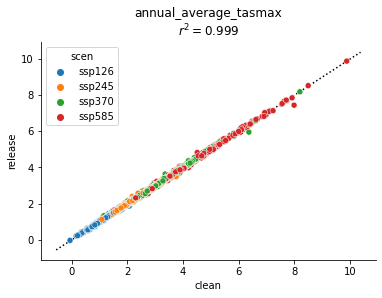

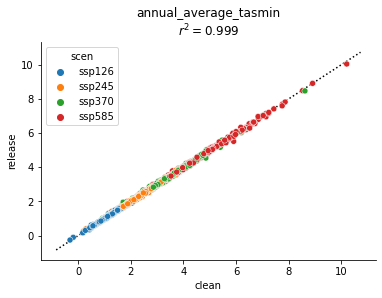

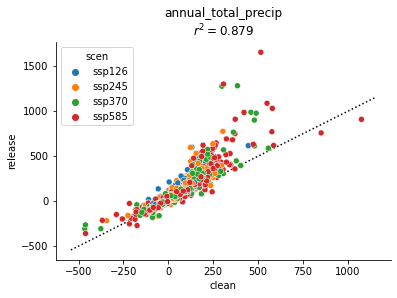

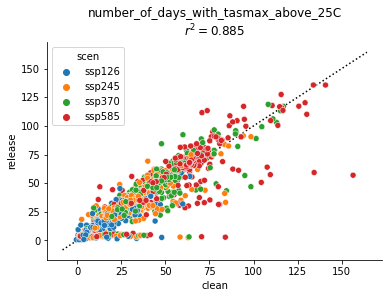

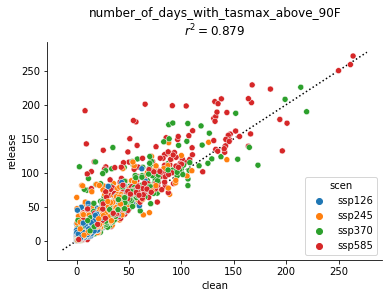

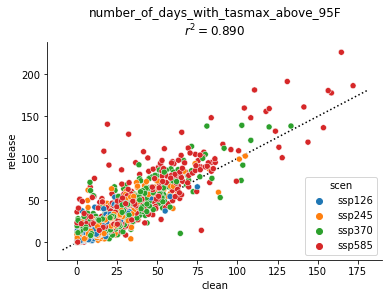

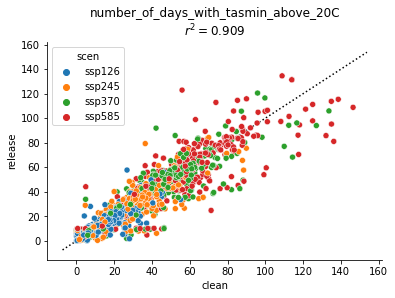

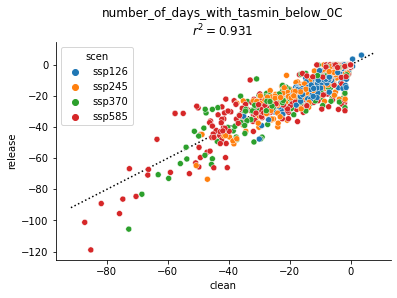

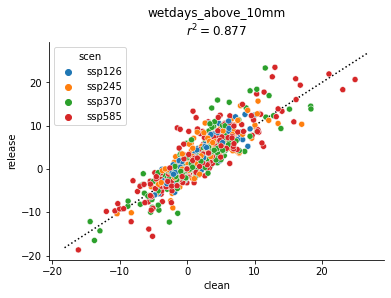

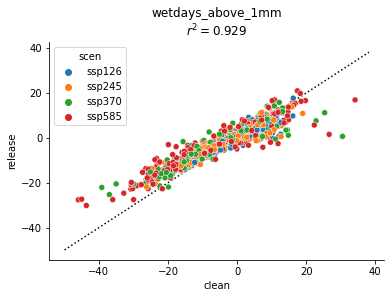

In [22]:
for v in annual_variables:
    df = pd.concat([
            (
                    all_data_adm0[m][v].sel(period=2089)
                    - all_data_adm0[m][v].sel(period=2004)
            ).expand_dims(source_id=[m]).to_series().unstack('stage').reset_index(drop=False)
            for m in all_data_adm0.keys()
    ]).reset_index(drop=True).rename_axis(None, axis=1)

    r2 = df['clean'].corr(df['release'])

    fig, ax = plt.subplots()
    sns.scatterplot(
        data=df,
        x='clean',
        y='release',
        hue='scen',
        ax=ax
    )

    ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='dotted', zorder=-1, color='k')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title('{}\n$r^2={:0.3f}$'.format(v, r2))

    fig.set_facecolor('white')

In [23]:
seasonal_average_tasmax = pd.concat([
        (
                all_data_adm0[m].seasonal_average_tasmax.sel(period=2089)
                - all_data_adm0[m].seasonal_average_tasmax.sel(period=2004)
        ).expand_dims(source_id=[m]).to_series().unstack('stage').reset_index(drop=False)
        for m in all_data_adm0.keys()
]).reset_index(drop=True).rename_axis(None, axis=1)

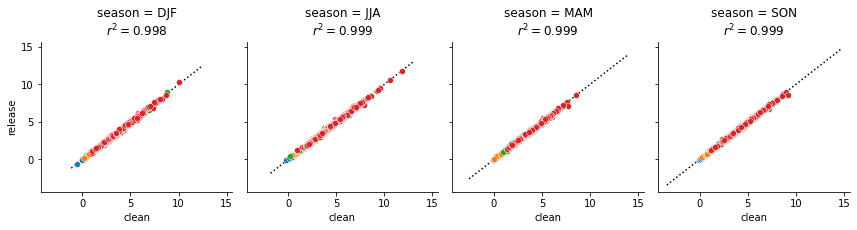

In [24]:
df = seasonal_average_tasmax

p = sns.FacetGrid(
    data=df,
    col='season',
    hue='scen',
    legend_out=True,
).map_dataframe(
    sns.scatterplot,
    x='clean',
    y='release',
)


corr = df.groupby('season').apply(lambda x: x['clean'].corr(x['release']))

for i, ax in enumerate(p.axes.flat):
    ax.set_title(ax.get_title() + '\n$r^2={:0.3f}$'.format(corr.iloc[i]))
    ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='dotted', zorder=-1, color='k')

p.fig.set_facecolor('white')

In [25]:
p.fig.get_size_inches()

array([12.,  3.])

In [84]:
seasonal_average_tasmax_adm1 = pd.concat([
        (
                all_data_adm1[m].seasonal_average_tasmax.sel(period=2089)
                - all_data_adm1[m].seasonal_average_tasmax.sel(period=2004)
        ).expand_dims(source_id=[m]).to_series().unstack('stage').reset_index(drop=False)
        for m in all_data_adm1.keys()
]).reset_index(drop=True).rename_axis(None, axis=1)

annual and seasonal tasmax - admin0


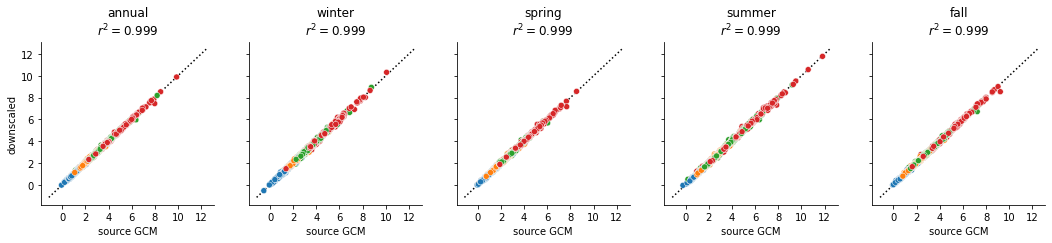

In [90]:
print('annual and seasonal tasmax - admin0')
fig, axes = plt.subplots(1, 5, figsize=(18, 3), sharey=True, sharex=True)

ax = axes[0]
df = pd.concat([
        (
                all_data_adm0[m]['annual_average_tasmax'].sel(period=2089)
                - all_data_adm0[m]['annual_average_tasmax'].sel(period=2004)
        ).expand_dims(source_id=[m]).to_series().unstack('stage').reset_index(drop=False)
        for m in all_data_adm0.keys()
]).reset_index(drop=True).rename_axis(None, axis=1)

r2 = df['clean'].corr(df['release'])

sns.scatterplot(
    data=df,
    x='clean',
    y='release',
    hue='scen',
    ax=ax,
    legend=False,
)

ax.set_title('{}\n$r^2={:0.3f}$'.format('annual', r2))

names = ['winter', 'spring', 'summer', 'fall']
for si, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    ax = axes[si + 1]

    df = seasonal_average_tasmax[seasonal_average_tasmax.season == season]

    h = sns.scatterplot(
        data=df,
        x='clean',
        y='release',
        hue='scen',
        ax=ax,
        legend=False,
    )

    corr = df['clean'].corr(df['release'])

    ax.set_title('{}\n$r^2={:0.3f}$'.format(names[si], r2))

# axes[2].legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3
#               )
minx, maxx = min([ax.get_xlim()[0] for ax in axes]), max([ax.get_xlim()[1] for ax in axes])
miny, maxy = min([ax.get_ylim()[0] for ax in axes]), max([ax.get_ylim()[1] for ax in axes])
minv, maxv = min(minx, miny), max(maxx, maxy)

for ax in axes.flat:
    ax.plot([minv, maxv], [minv, maxv], linestyle='dotted', zorder=-1, color='k')
    ax.set_xticks(np.arange(0, 14, 2))
    ax.set_yticks(np.arange(0, 14, 2))
#     ax.set_xticklabels([t.get_text() for t in axes[0].get_yticklabels()])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('source GCM')

axes[0].set_ylabel('downscaled')

fig.set_facecolor('white')

annual and seasonal tasmax - admin1


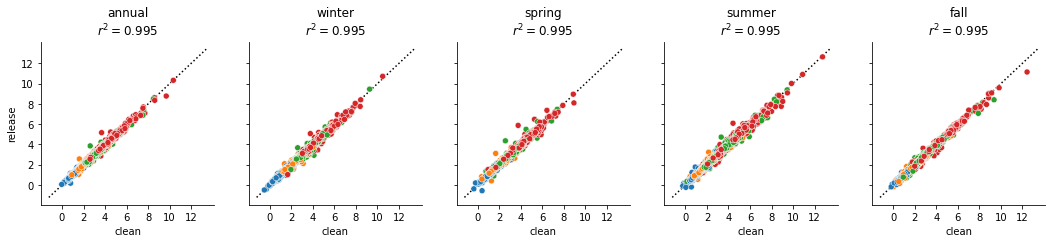

In [86]:
print('annual and seasonal tasmax - admin1')

fig, axes = plt.subplots(1, 5, figsize=(18, 3), sharey=True, sharex=True)

ax = axes[0]
df = pd.concat([
        (
                all_data_adm1[m]['annual_average_tasmax'].sel(period=2089)
                - all_data_adm1[m]['annual_average_tasmax'].sel(period=2004)
        ).expand_dims(source_id=[m]).to_series().unstack('stage').reset_index(drop=False)
        for m in all_data_adm1.keys()
]).reset_index(drop=True).rename_axis(None, axis=1)

r2 = df['clean'].corr(df['release'])

sns.scatterplot(
    data=df,
    x='clean',
    y='release',
    hue='scen',
    ax=ax,
    legend=False,
)

ax.set_title('{}\n$r^2={:0.3f}$'.format('annual', r2))

names = ['winter', 'spring', 'summer', 'fall']
for si, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    ax = axes[si + 1]

    df = seasonal_average_tasmax_adm1[seasonal_average_tasmax_adm1.season == season]

    h = sns.scatterplot(
        data=df,
        x='clean',
        y='release',
        hue='scen',
        ax=ax,
        legend=False,
    )

    corr = df['clean'].corr(df['release'])

    ax.set_title('{}\n$r^2={:0.3f}$'.format(names[si], r2))

# axes[2].legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3
#               )
minx, maxx = min([ax.get_xlim()[0] for ax in axes]), max([ax.get_xlim()[1] for ax in axes])
miny, maxy = min([ax.get_ylim()[0] for ax in axes]), max([ax.get_ylim()[1] for ax in axes])
minv, maxv = min(minx, miny), max(maxx, maxy)

for ax in axes.flat:
    ax.plot([minv, maxv], [minv, maxv], linestyle='dotted', zorder=-1, color='k')
    ax.set_xticks(np.arange(0, 14, 2))
    ax.set_yticks(np.arange(0, 14, 2))
#     ax.set_xticklabels([t.get_text() for t in axes[0].get_yticklabels()])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.set_facecolor('white')

In [74]:
t = axes[0].get_yticklabels()[0]

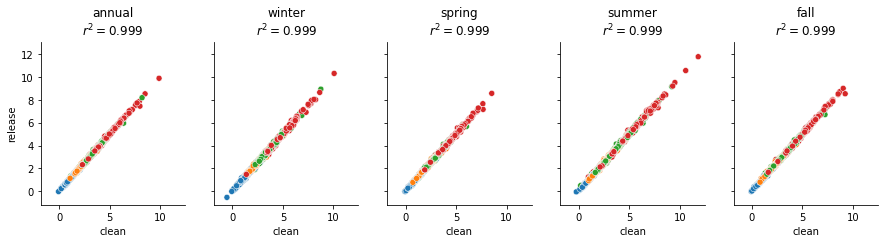

In [60]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True, sharex=True)

ax = axes[0]
df = pd.concat([
        (
                all_data_adm0[m]['annual_average_tasmax'].sel(period=2089)
                - all_data_adm0[m]['annual_average_tasmax'].sel(period=2004)
        ).expand_dims(source_id=[m]).to_series().unstack('stage').reset_index(drop=False)
        for m in all_data_adm0.keys()
]).reset_index(drop=True).rename_axis(None, axis=1)

r2 = df['clean'].corr(df['release'])

sns.scatterplot(
    data=df,
    x='clean',
    y='release',
    hue='scen',
    ax=ax,
    legend=False,
)

ax.set_title('{}\n$r^2={:0.3f}$'.format('annual', r2))

names = ['winter', 'spring', 'summer', 'fall']
for si, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    ax = axes[si + 1]

    df = seasonal_average_tasmax[seasonal_average_tasmax.season == season]

    h = sns.scatterplot(
        data=df,
        x='clean',
        y='release',
        hue='scen',
        ax=ax,
        legend=False,
    )

    corr = df['clean'].corr(df['release'])

    ax.set_title('{}\n$r^2={:0.3f}$'.format(names[si], r2))

# axes[2].legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3
#               )
minx, maxx = min([ax.get_xlim()[0] for ax in axes]), max([ax.get_xlim()[1] for ax in axes])
for ax in axes.flat:
    ax.plot(minx, maxx, linestyle='dotted', zorder=-1, color='k')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.set_facecolor('white')

In [67]:
axes[0].get_yticklabels()

[Text(0, -2.0, '−2'),
 Text(0, 0.0, '0'),
 Text(0, 2.0, '2'),
 Text(0, 4.0, '4'),
 Text(0, 6.0, '6'),
 Text(0, 8.0, '8'),
 Text(0, 10.0, '10'),
 Text(0, 12.0, '12'),
 Text(0, 14.0, '14')]

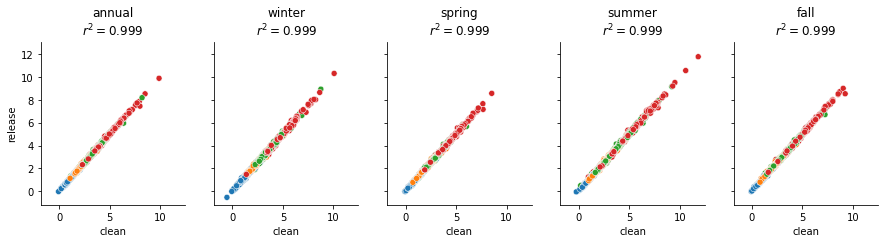

In [60]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharey=True, sharex=True)

ax = axes[0]
df = pd.concat([
        (
                all_data_adm0[m]['annual_average_tasmax'].sel(period=2089)
                - all_data_adm0[m]['annual_average_tasmax'].sel(period=2004)
        ).expand_dims(source_id=[m]).to_series().unstack('stage').reset_index(drop=False)
        for m in all_data_adm0.keys()
]).reset_index(drop=True).rename_axis(None, axis=1)

r2 = df['clean'].corr(df['release'])

sns.scatterplot(
    data=df,
    x='clean',
    y='release',
    hue='scen',
    ax=ax,
    legend=False,
)

ax.set_title('{}\n$r^2={:0.3f}$'.format('annual', r2))

names = ['winter', 'spring', 'summer', 'fall']
for si, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    ax = axes[si + 1]

    df = seasonal_average_tasmax[seasonal_average_tasmax.season == season]

    h = sns.scatterplot(
        data=df,
        x='clean',
        y='release',
        hue='scen',
        ax=ax,
        legend=False,
    )

    corr = df['clean'].corr(df['release'])

    ax.set_title('{}\n$r^2={:0.3f}$'.format(names[si], r2))

# axes[2].legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05),
#           ncol=3
#               )
minx, maxx = min([ax.get_xlim()[0] for ax in axes]), max([ax.get_xlim()[1] for ax in axes])
for ax in axes.flat:
    ax.plot(minx, maxx, linestyle='dotted', zorder=-1, color='k')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.set_facecolor('white')

In [ ]:
h.collections[0].get_label()

In [45]:
seasonal_average_tasmin = pd.concat([
        (
                all_data_adm0[m].seasonal_average_tasmin.sel(period=2089)
                - all_data_adm0[m].seasonal_average_tasmin.sel(period=2004)
        ).expand_dims(source_id=[m]).to_series().unstack('stage').reset_index(drop=False)
        for m in all_data_adm0.keys()
]).reset_index(drop=True).rename_axis(None, axis=1)

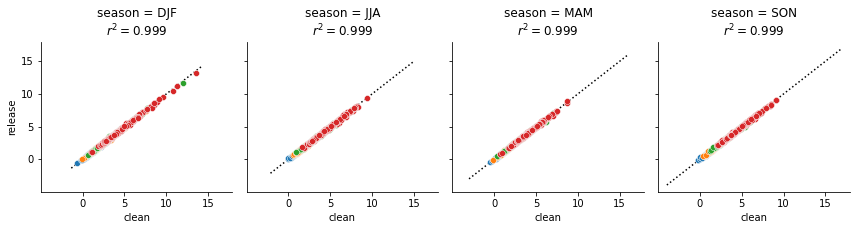

In [46]:
df = seasonal_average_tasmin

p = sns.FacetGrid(
    data=df,
    col='season',
    hue='scen',
    legend_out=True,
).map_dataframe(
    sns.scatterplot,
    x='clean',
    y='release',
)


corr = df.groupby('season').apply(lambda x: x['clean'].corr(x['release']))

for i, ax in enumerate(p.axes.flat):
    ax.set_title(ax.get_title() + '\n$r^2={:0.3f}$'.format(corr.iloc[i]))
    ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='dotted', zorder=-1, color='k')

p.fig.set_facecolor('white')

In [24]:
seasonal_total_precip = pd.concat([
        (
                all_data_adm0[m].seasonal_total_precip.sel(period=2089)
                - all_data_adm0[m].seasonal_total_precip.sel(period=2004)
        ).expand_dims(source_id=[m]).to_series().unstack('stage').reset_index(drop=False)
        for m in all_data_adm0.keys()
]).reset_index(drop=True).rename_axis(None, axis=1)

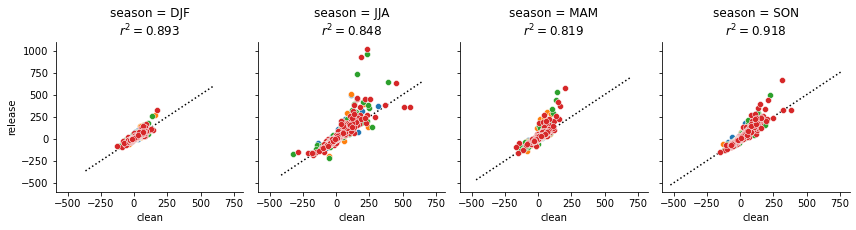

In [25]:
df = seasonal_total_precip

p = sns.FacetGrid(
    data=df,
    col='season',
    hue='scen',
    legend_out=True,
).map_dataframe(
    sns.scatterplot,
    x='clean',
    y='release',
)

corr = df.groupby('season').apply(lambda x: x['clean'].corr(x['release']))

for i, ax in enumerate(p.axes.flat):
    ax.set_title(ax.get_title() + '\n$r^2={:0.3f}$'.format(corr.iloc[i]))
    ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='dotted', zorder=-1, color='k')

p.fig.set_facecolor('white')

In [26]:
log_seasonal_total_precip = pd.concat([
        (
                np.log(all_data_adm0[m].seasonal_total_precip.sel(period=2089))
                - np.log(all_data_adm0[m].seasonal_total_precip.sel(period=2004))
        ).expand_dims(source_id=[m]).to_series().unstack('stage').reset_index(drop=False)
        for m in all_data_adm0.keys()
]).reset_index(drop=True).rename_axis(None, axis=1)

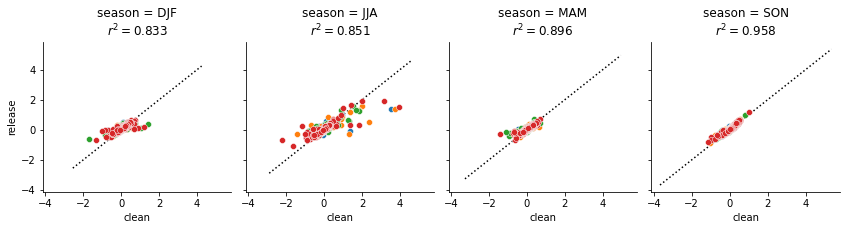

In [27]:
df = log_seasonal_total_precip

p = sns.FacetGrid(
    data=df,
    col='season',
    hue='scen',
    legend_out=True,
).map_dataframe(
    sns.scatterplot,
    x='clean',
    y='release',
)

corr = df.groupby('season').apply(lambda x: x['clean'].corr(x['release']))

for i, ax in enumerate(p.axes.flat):
    ax.set_title(ax.get_title() + '\n$r^2={:0.3f}$'.format(corr.iloc[i]))
    ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='dotted', zorder=-1, color='k')

p.fig.set_facecolor('white')

# Model-specific changes across time periods

### admin 1

In [28]:
source_id = 'UKESM1-0-LL'
experiment_id = 'ssp370'

assert experiment_id in models_dict[source_id], f"choose from {models_dict[source_id]}"

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/plot/facetgrid.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(


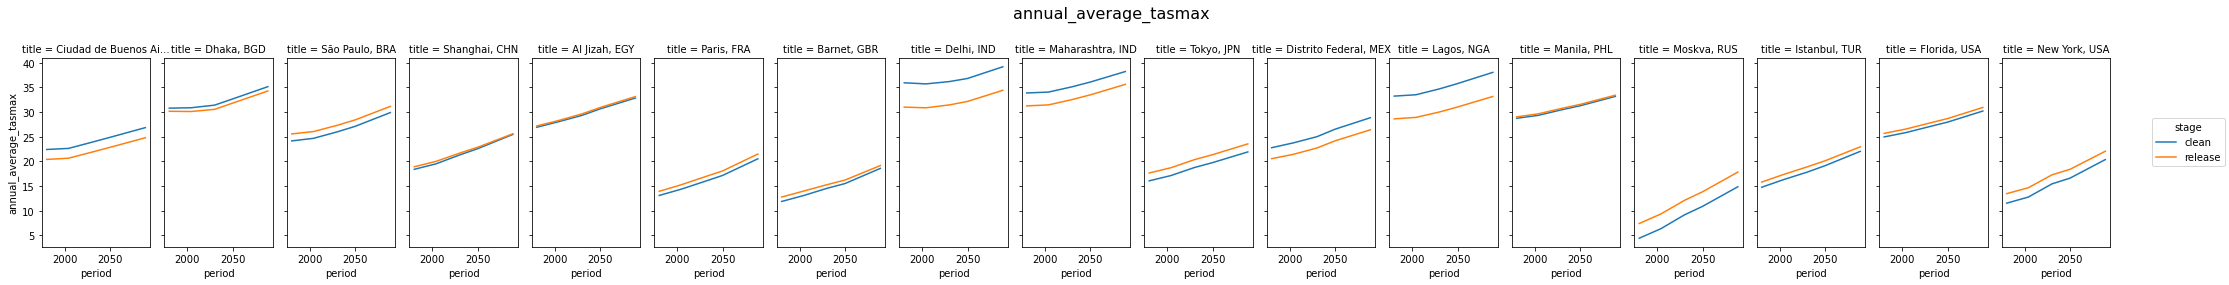

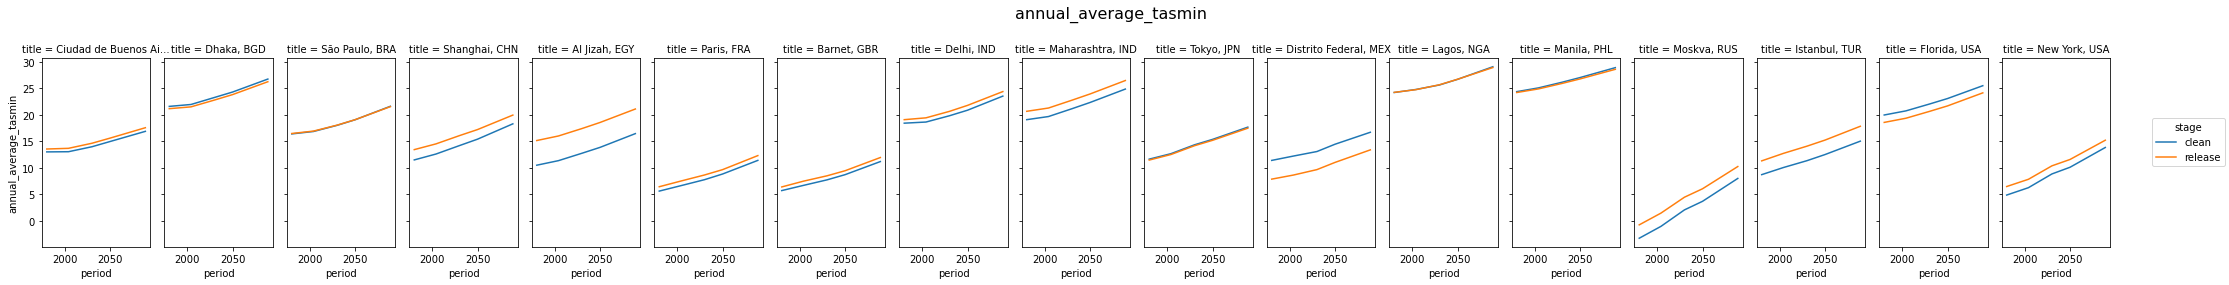

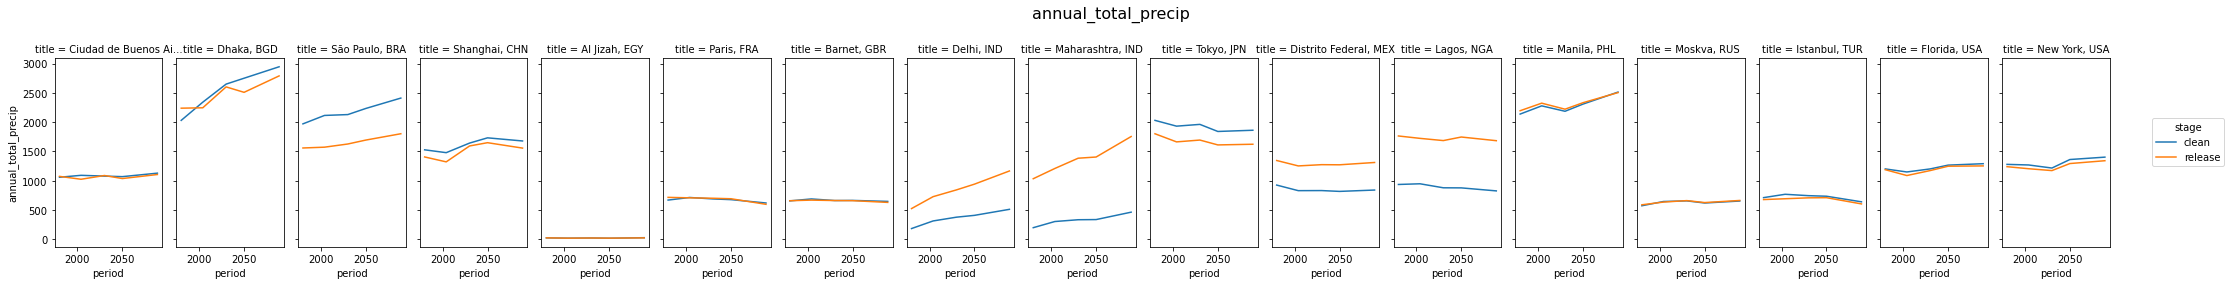

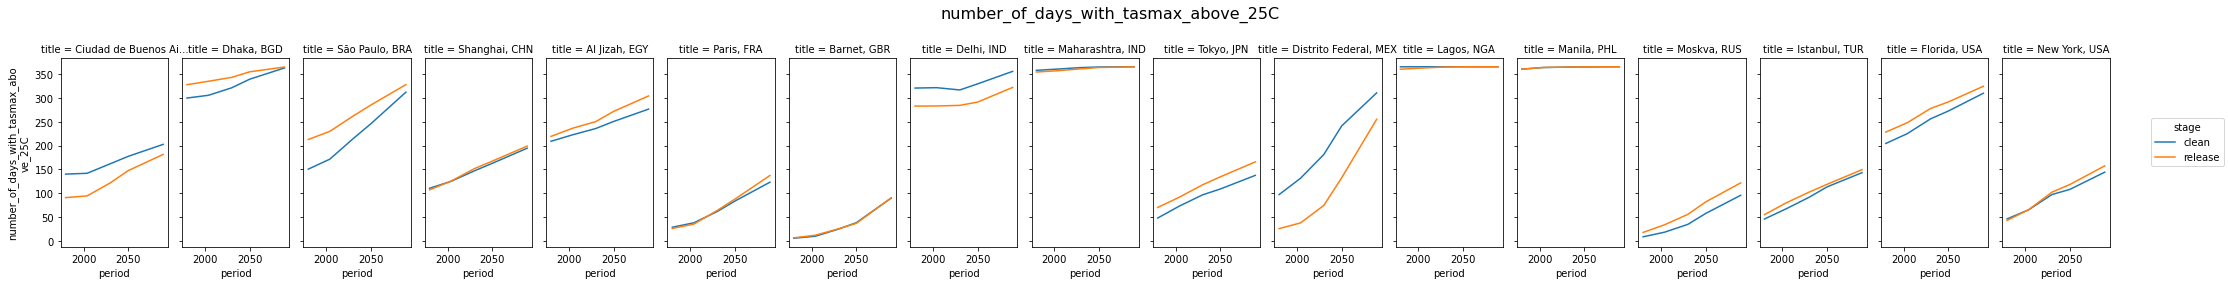

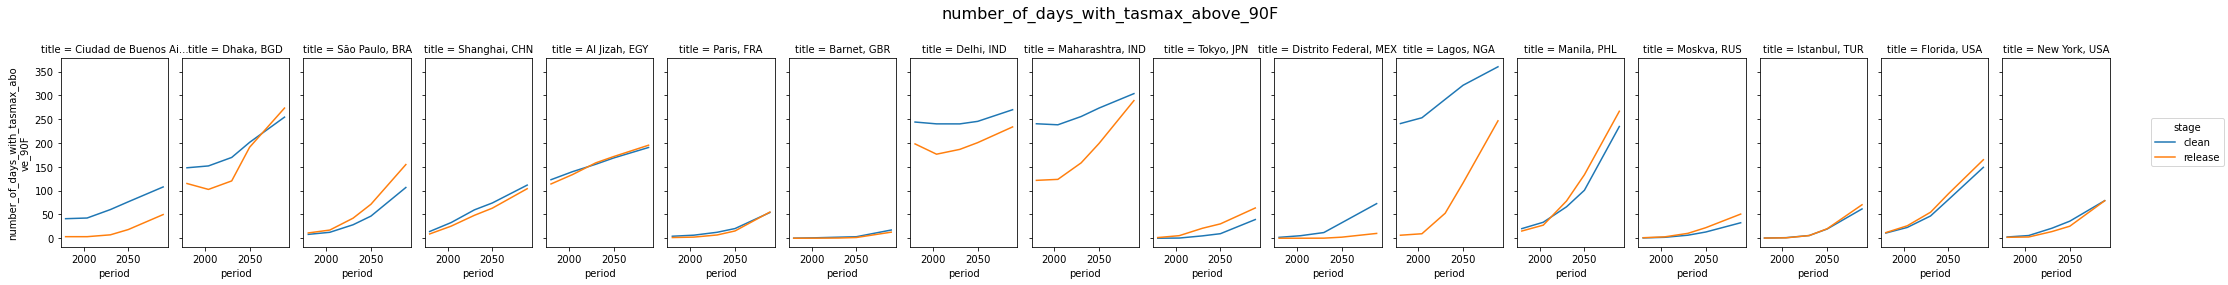

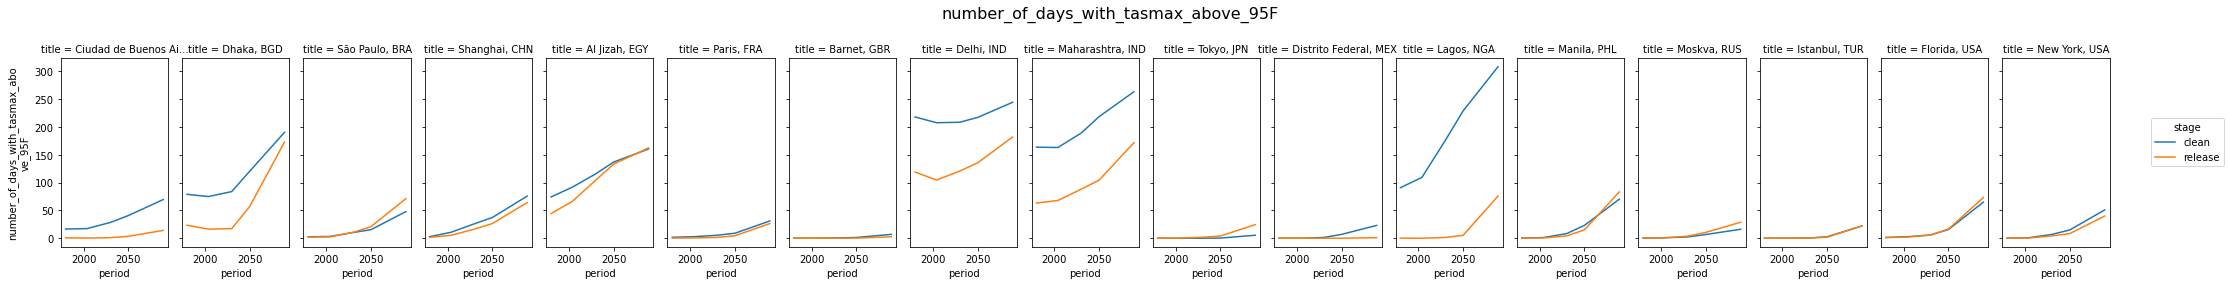

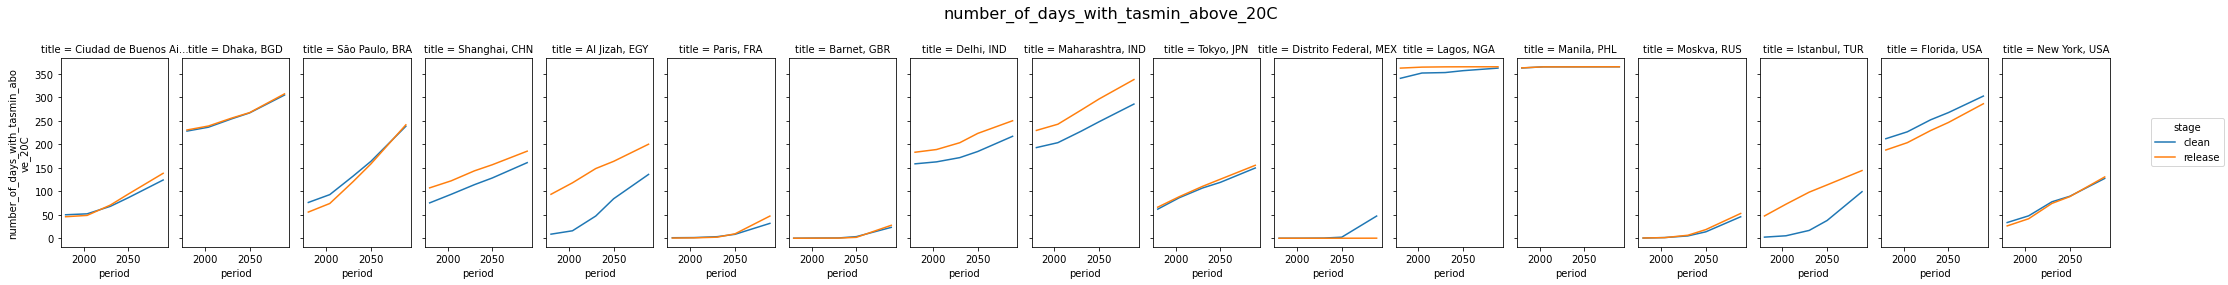

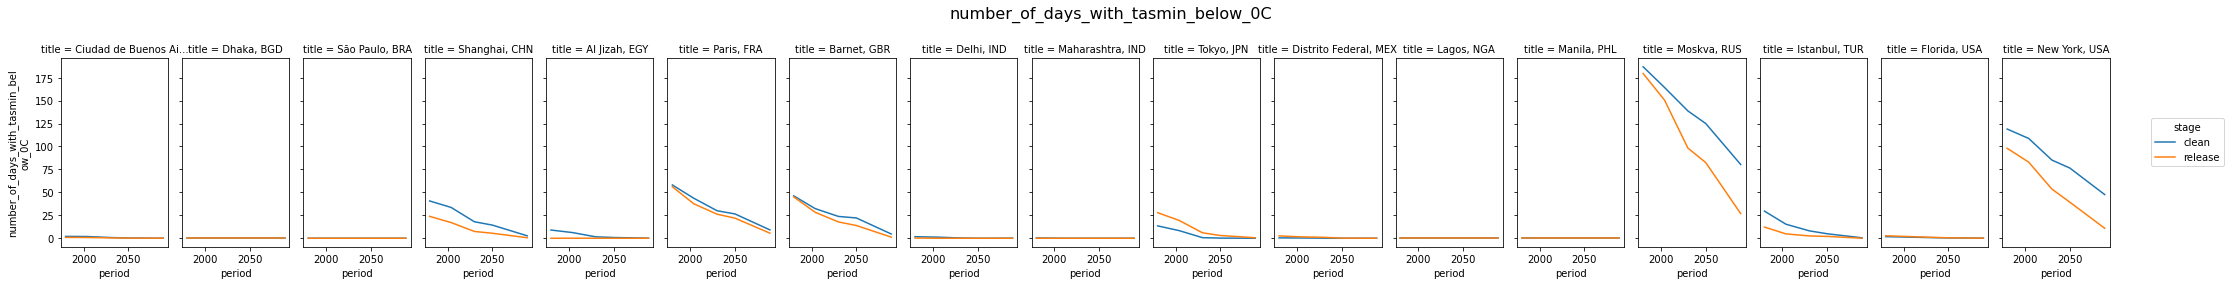

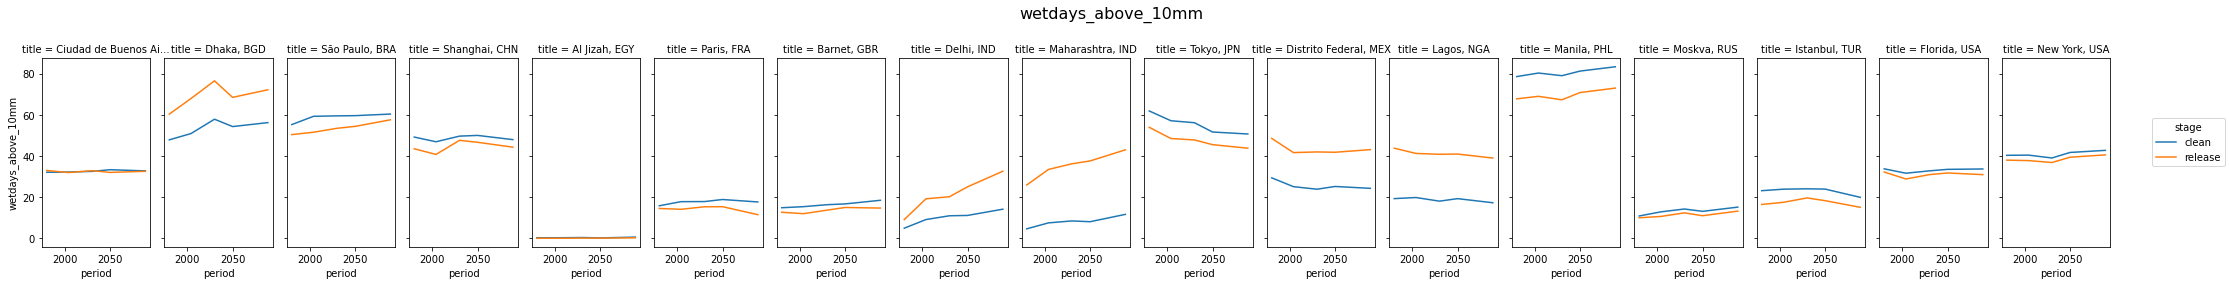

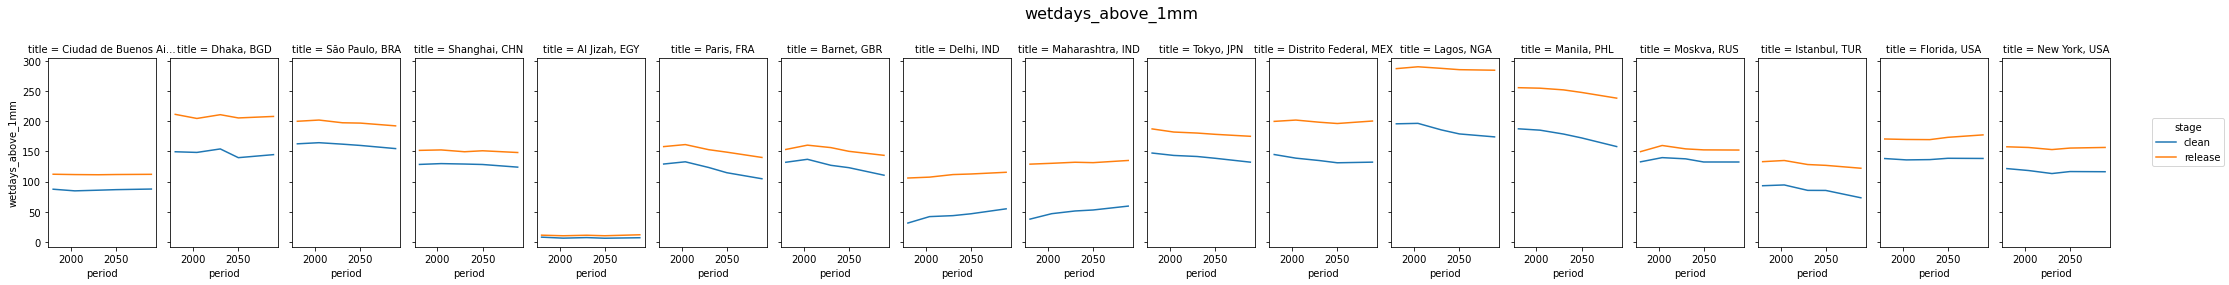

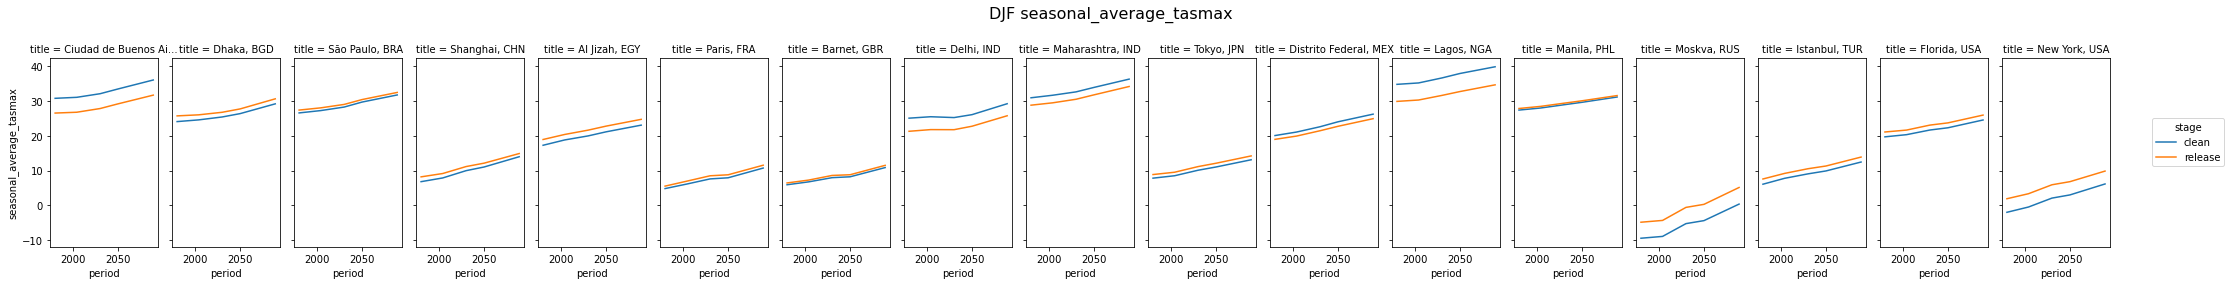

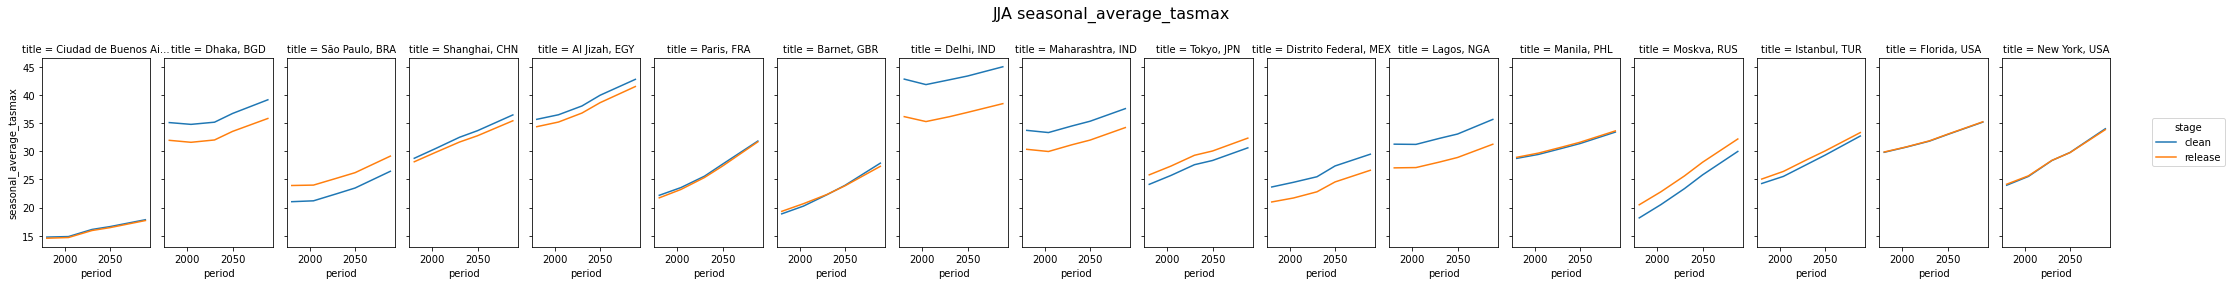

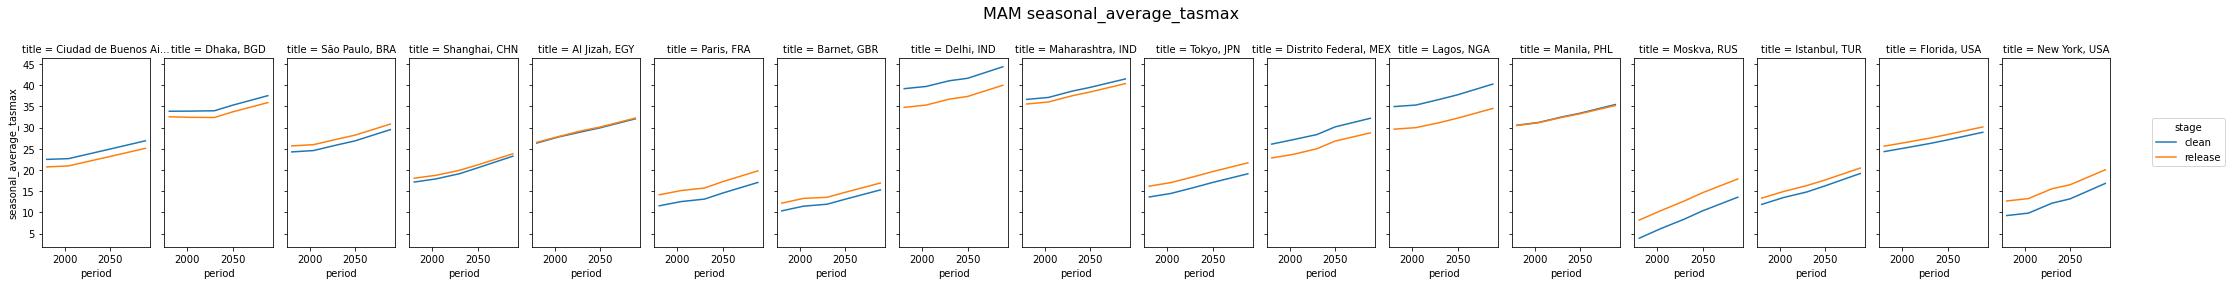

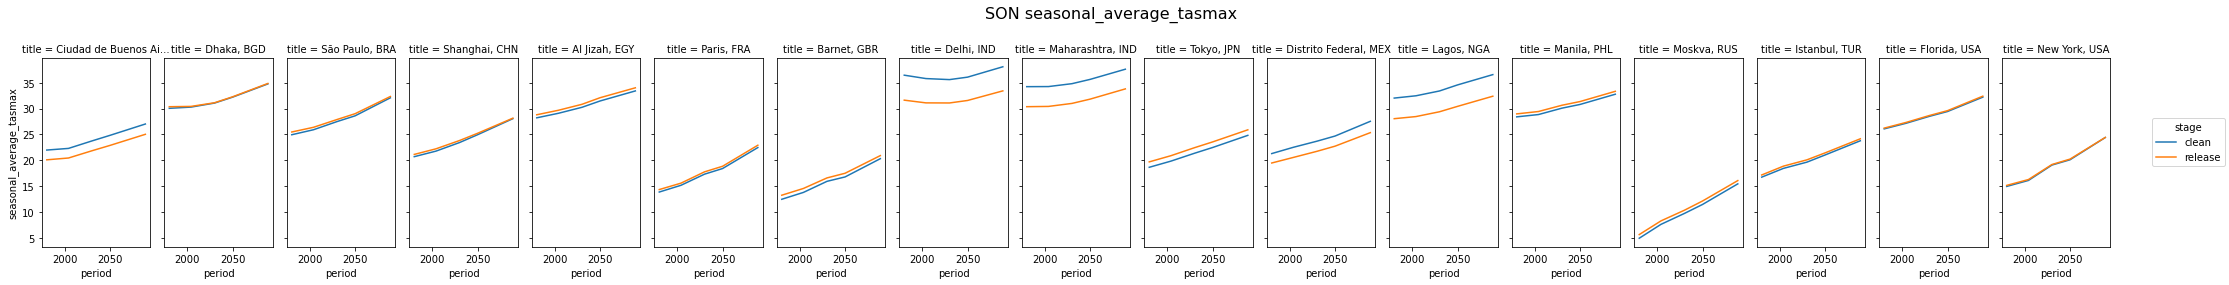

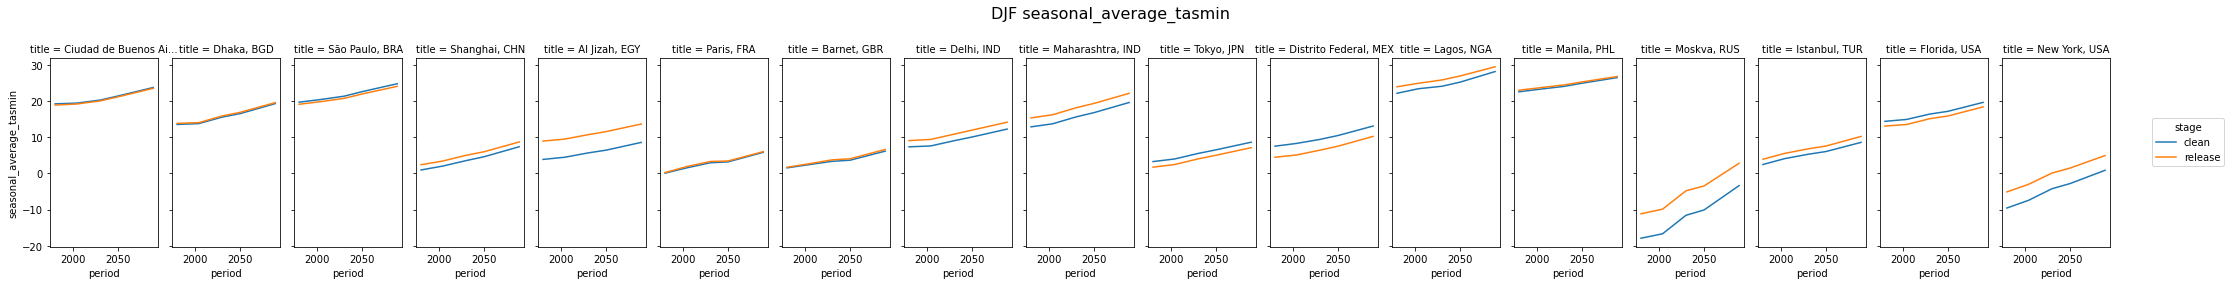

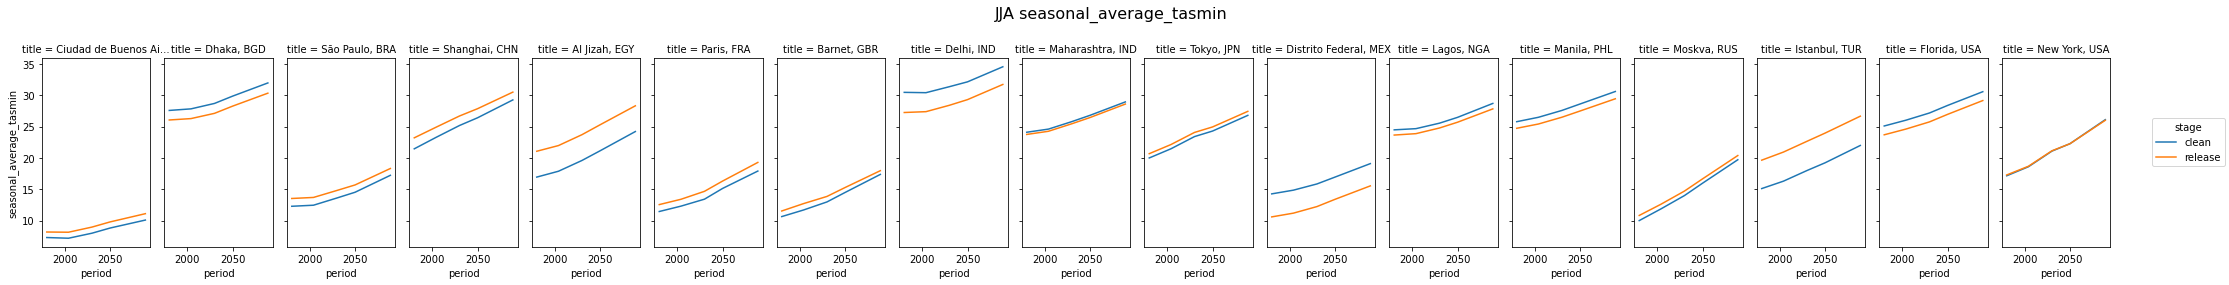

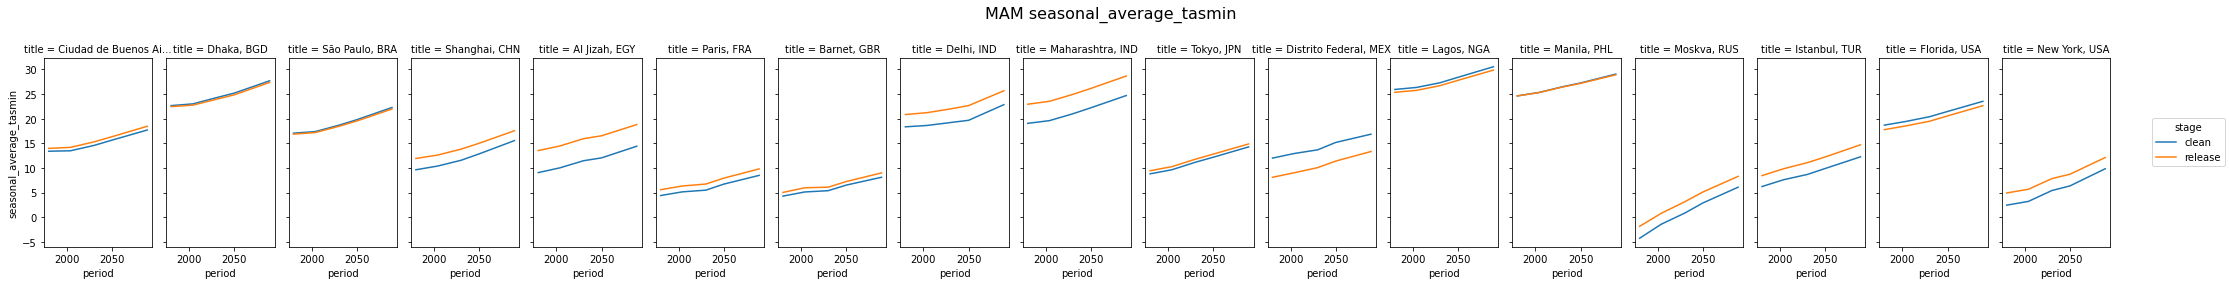

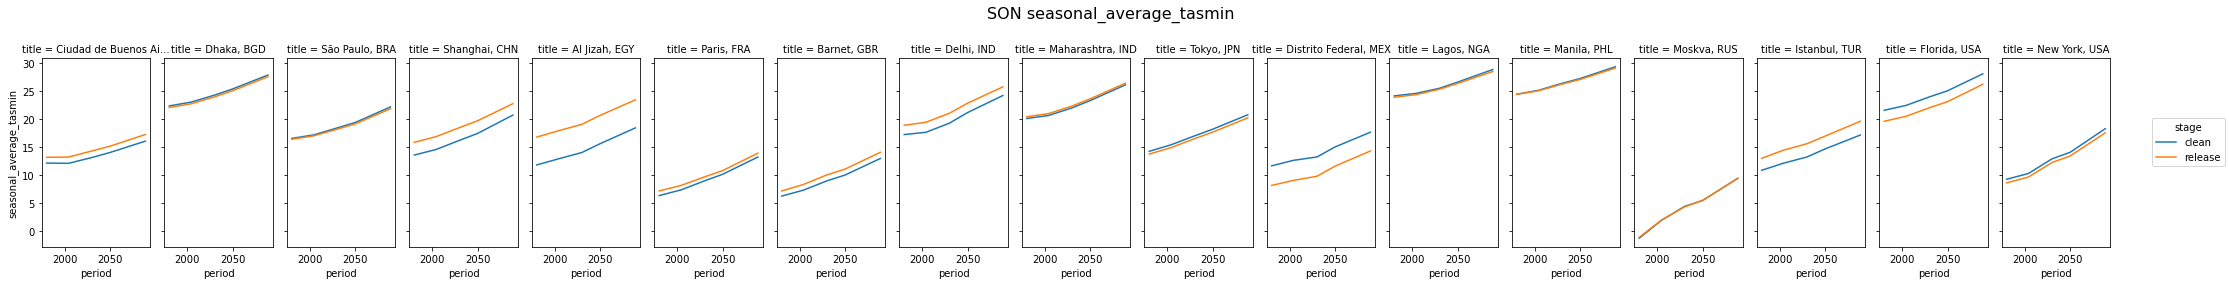

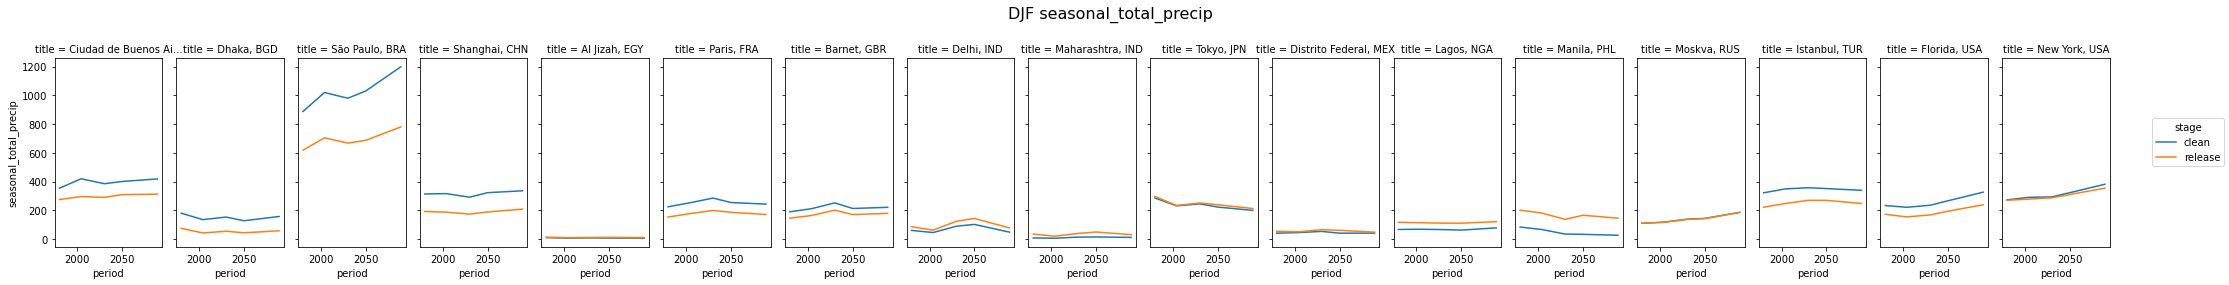

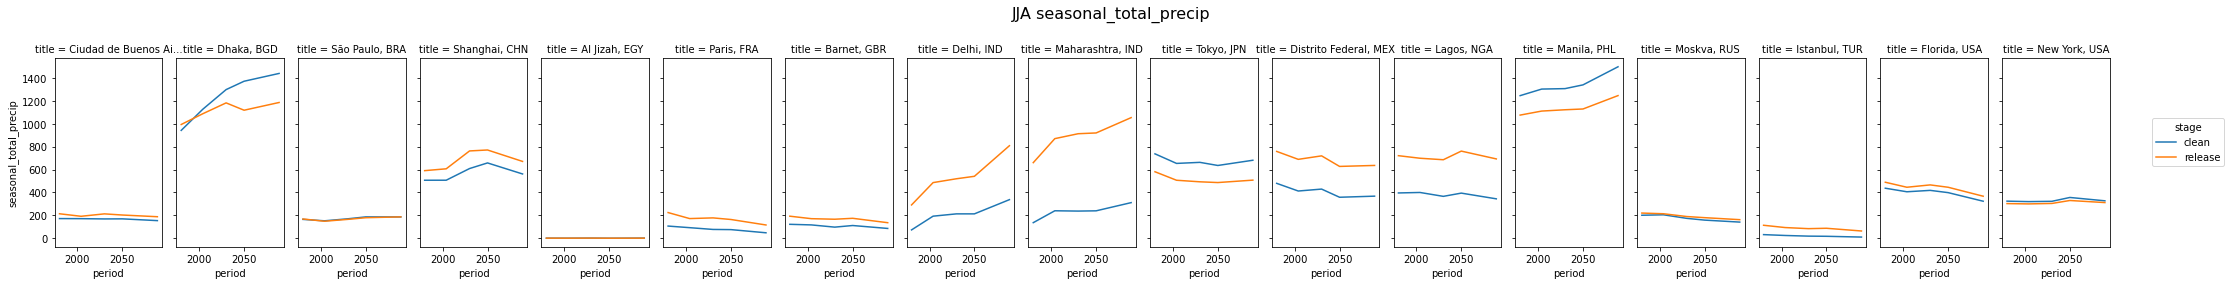

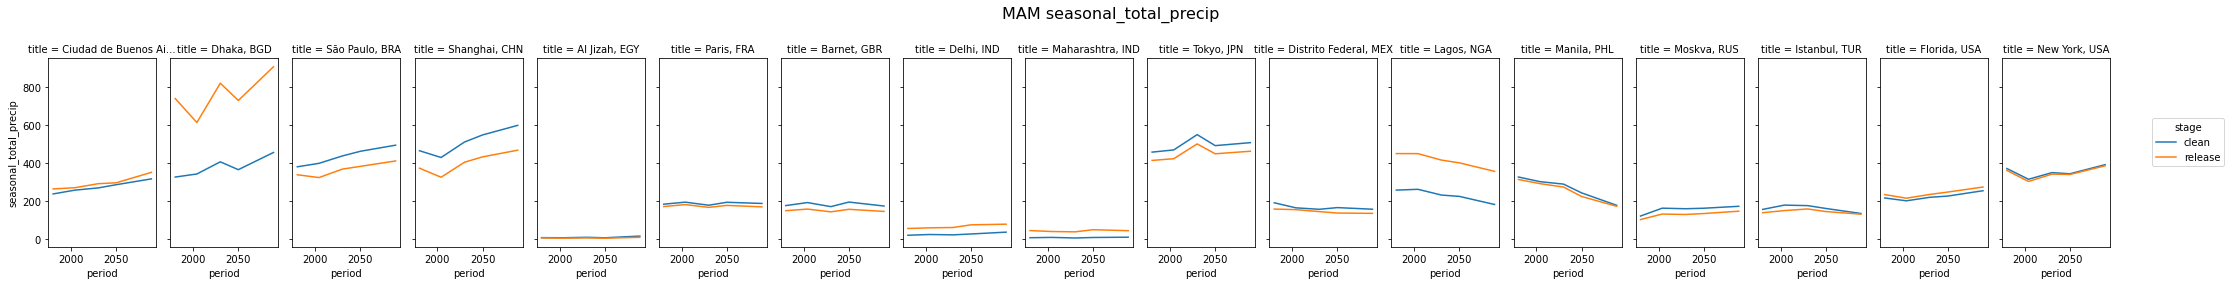

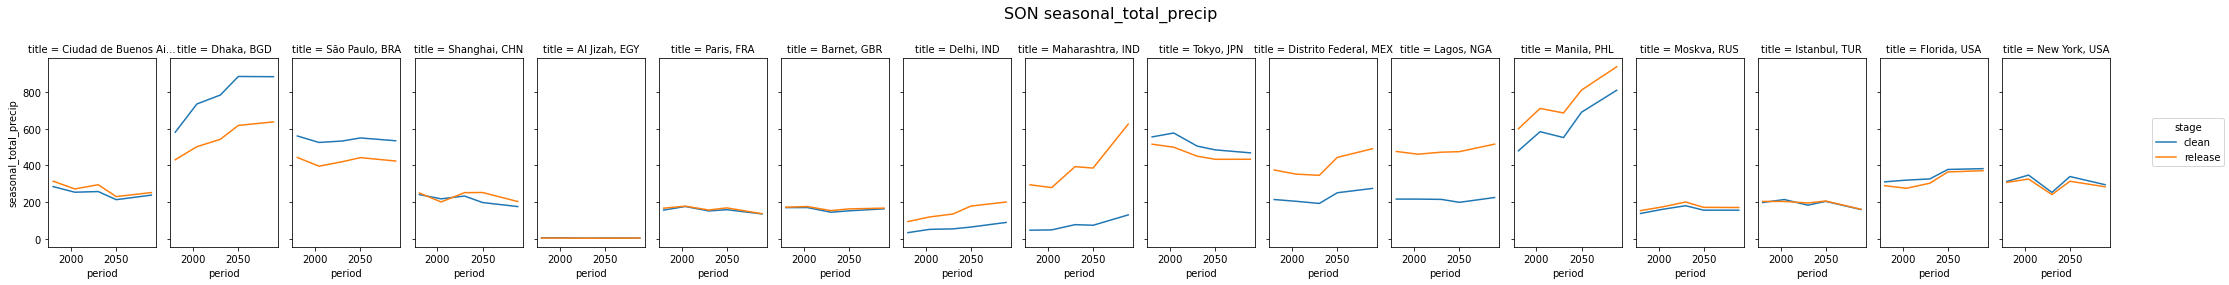

In [43]:
ds = all_data_adm1[source_id].sel(scen=experiment_id)

for v in ds.data_vars.keys():
    if 'season' in ds[v].dims:
        continue

    p = ds[v].swap_dims({'adm1_code': 'title'}).plot.line(x='period', col='title', figsize=(30, 4))
    p.fig.suptitle(f'{v}', size=16)
    p.fig.subplots_adjust(top=0.8)
    p.fig.set_facecolor('white')

for v in ds.data_vars.keys():

    if 'season' not in ds[v].dims:
        continue

    for season in ds[v].season.values:
        p = ds[v].swap_dims({'adm1_code': 'title'}).sel(season=season).plot.line(x='period', col='title', figsize=(30, 4))

        p.fig.suptitle(f'{season} {v}', size=16)

        p.fig.subplots_adjust(top=0.8)
        p.fig.set_facecolor('white')

# admin 0 

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/plot/facetgrid.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(


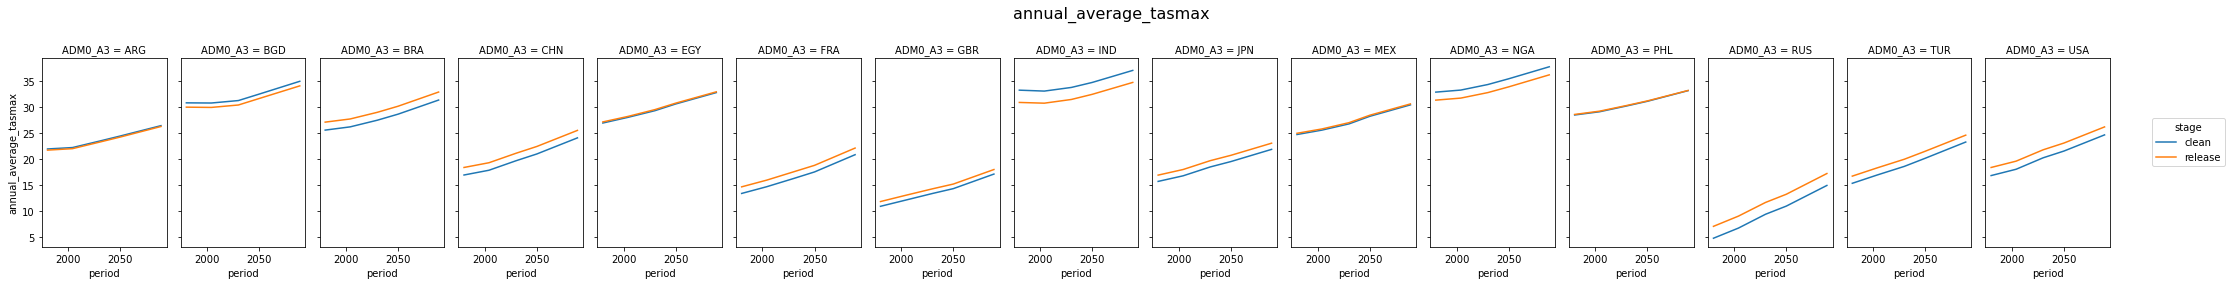

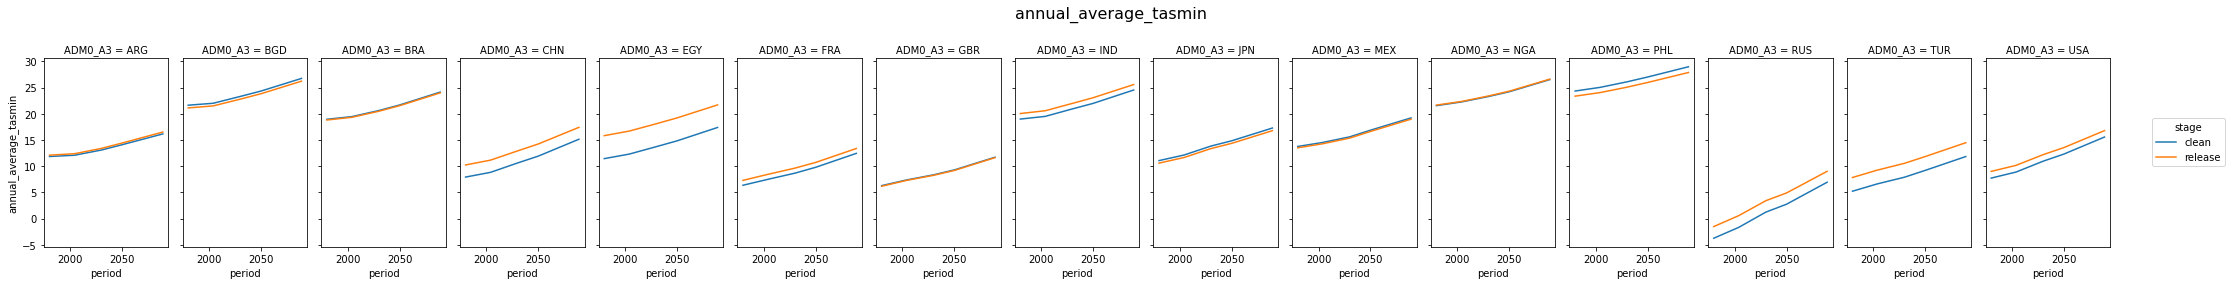

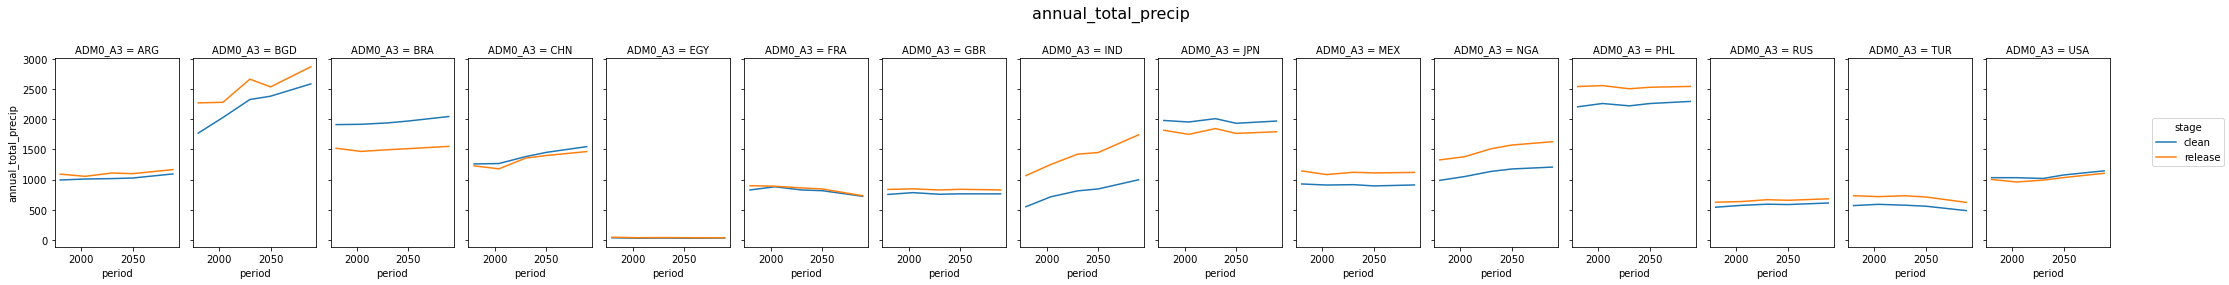

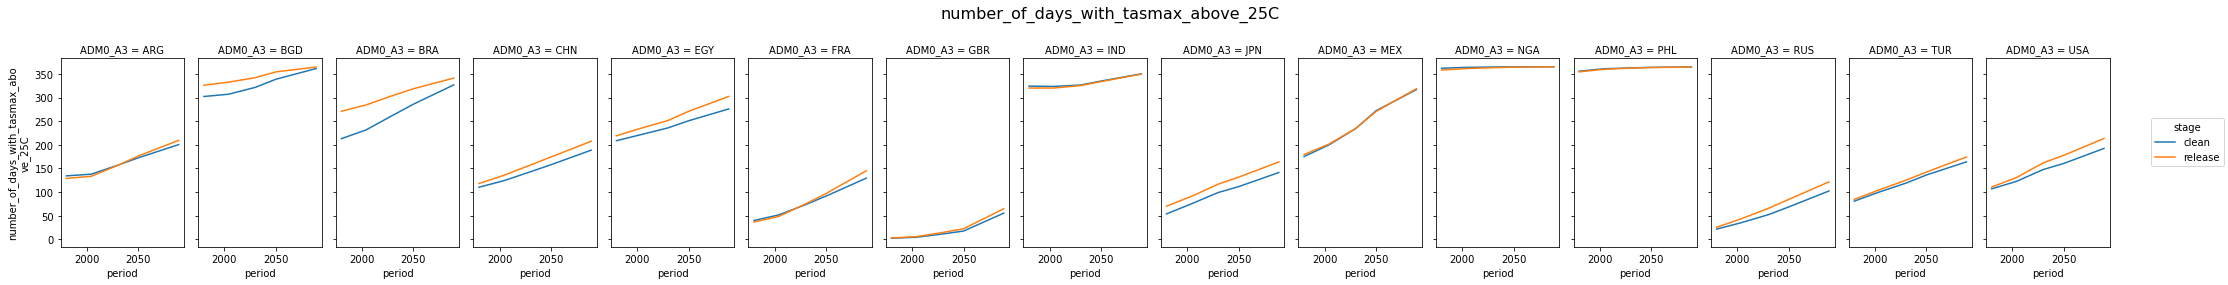

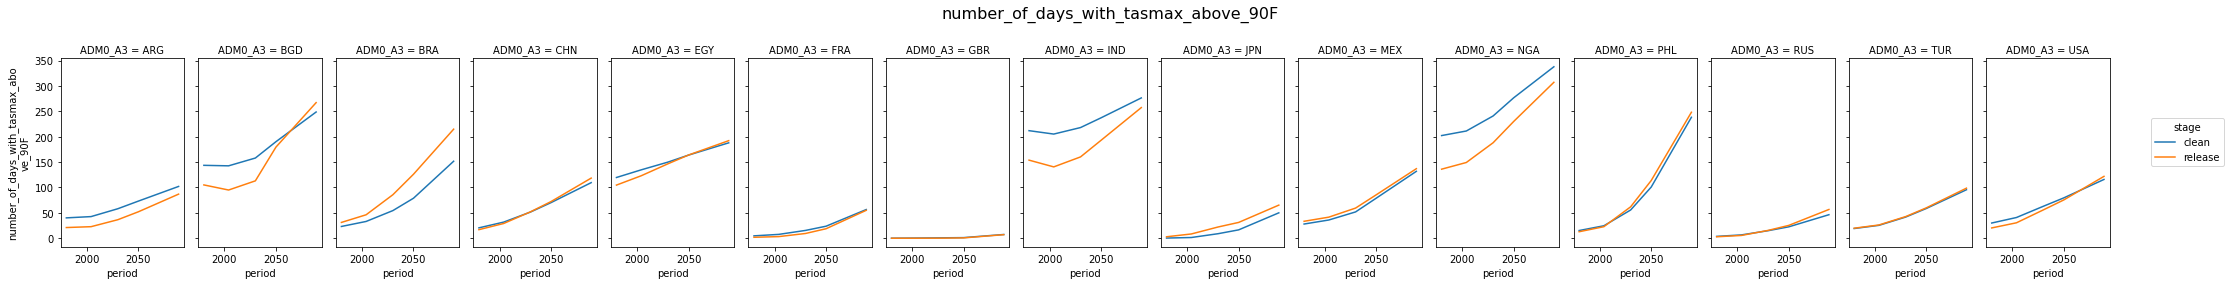

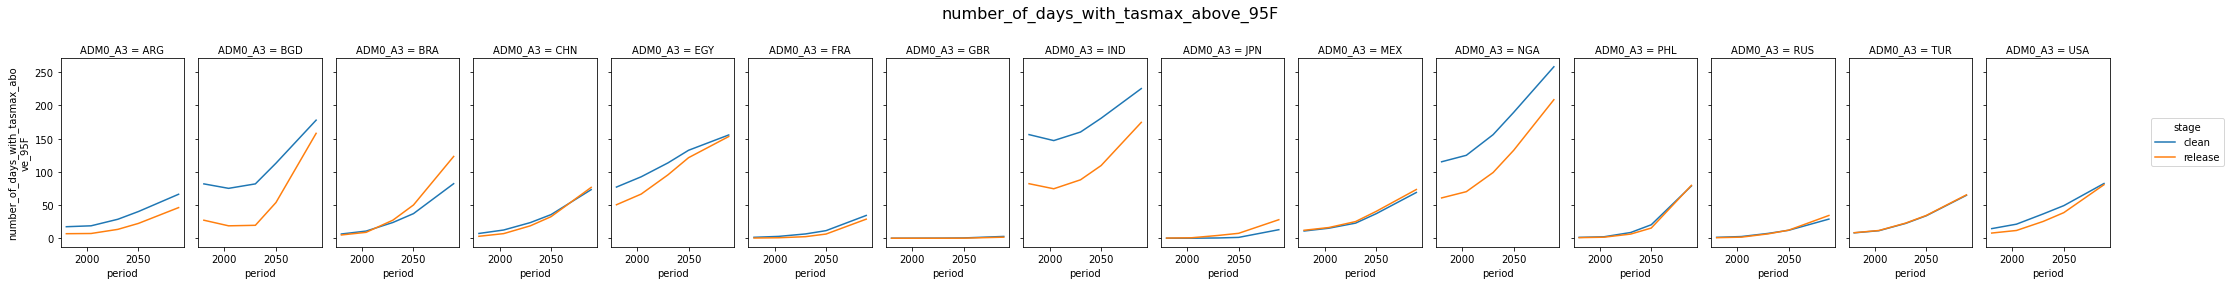

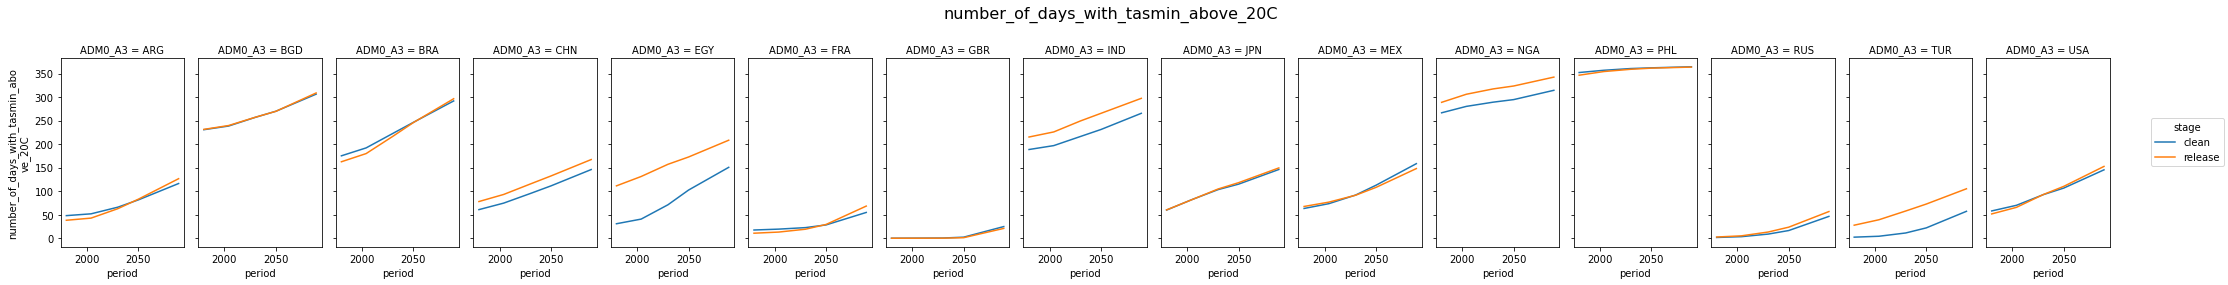

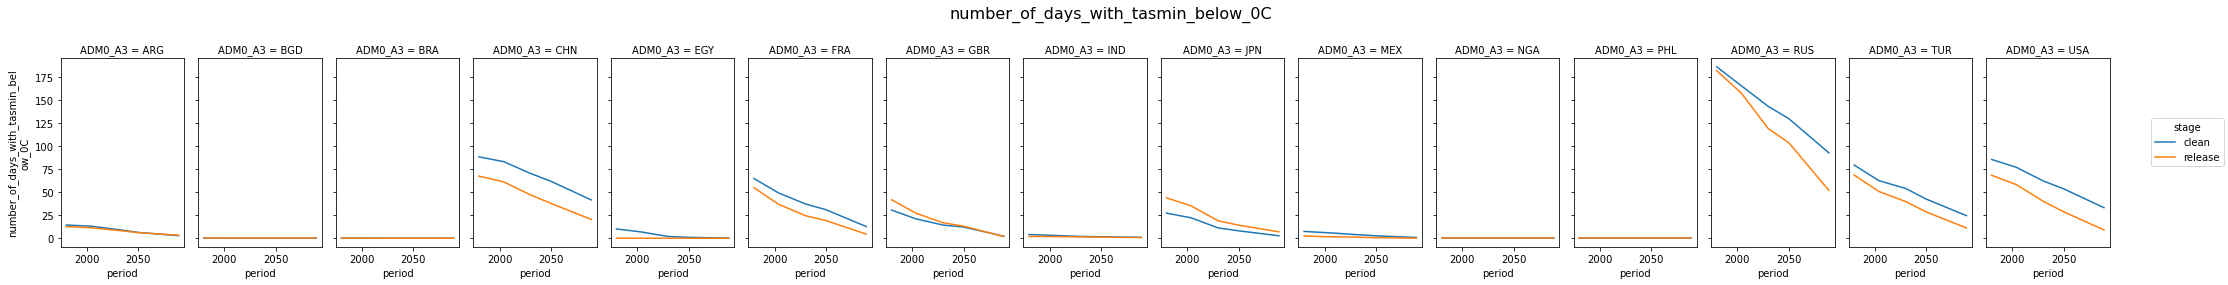

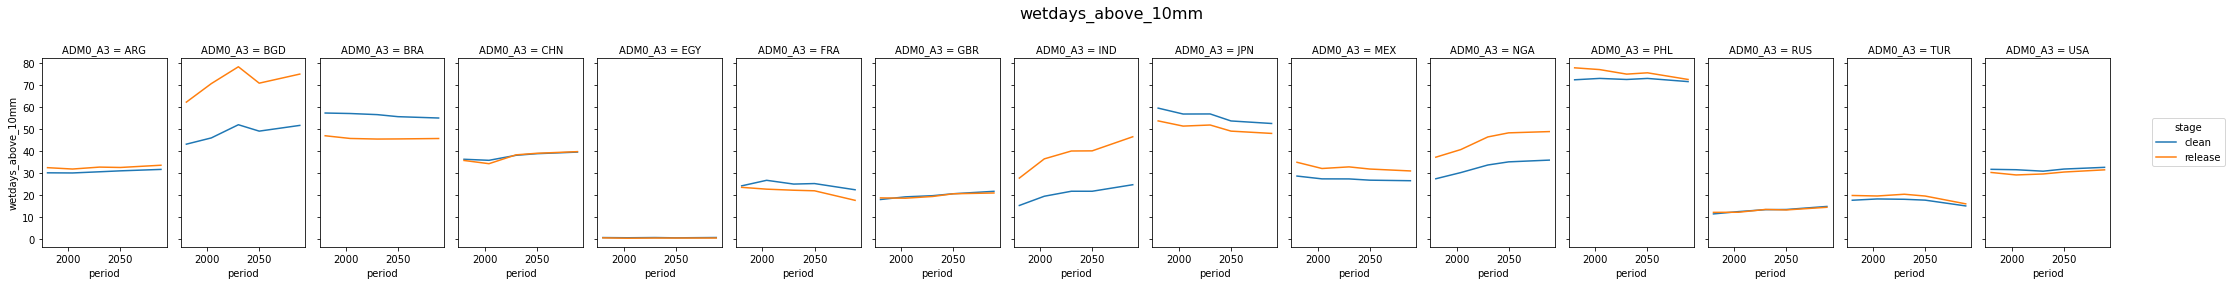

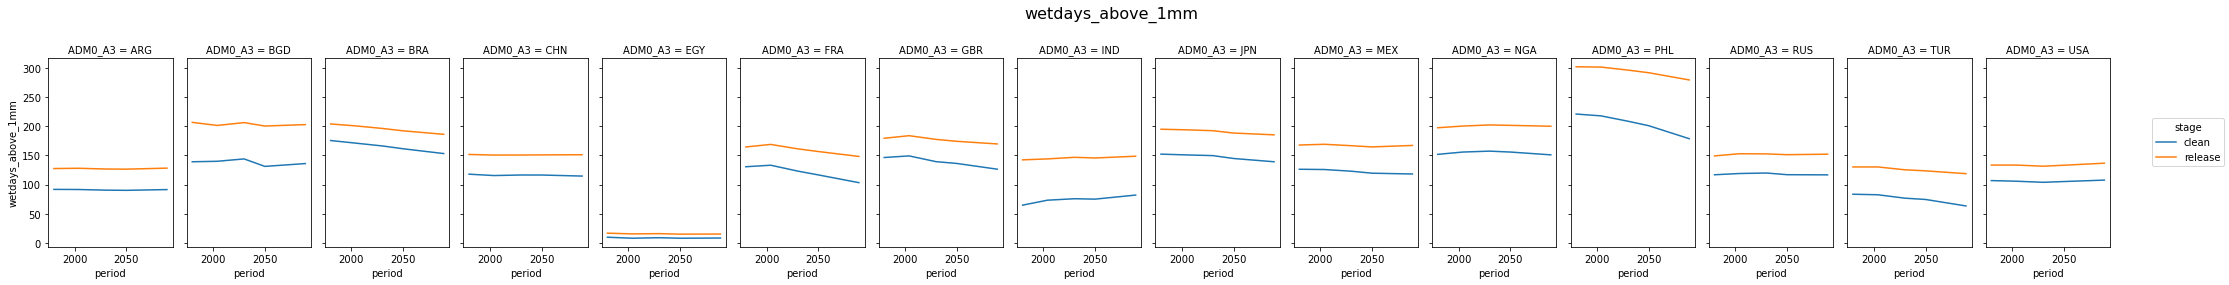

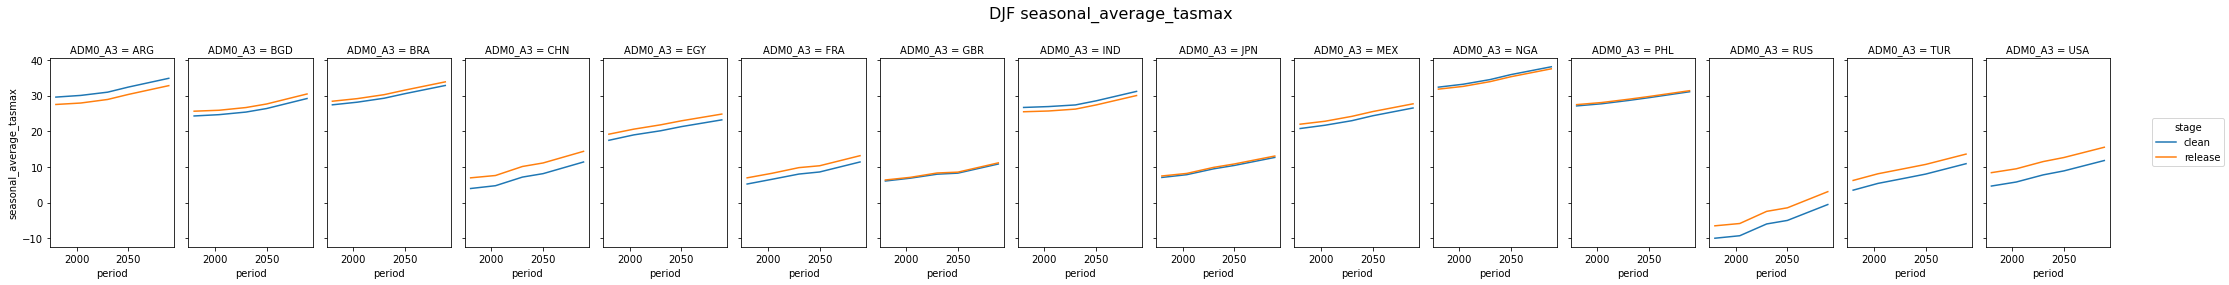

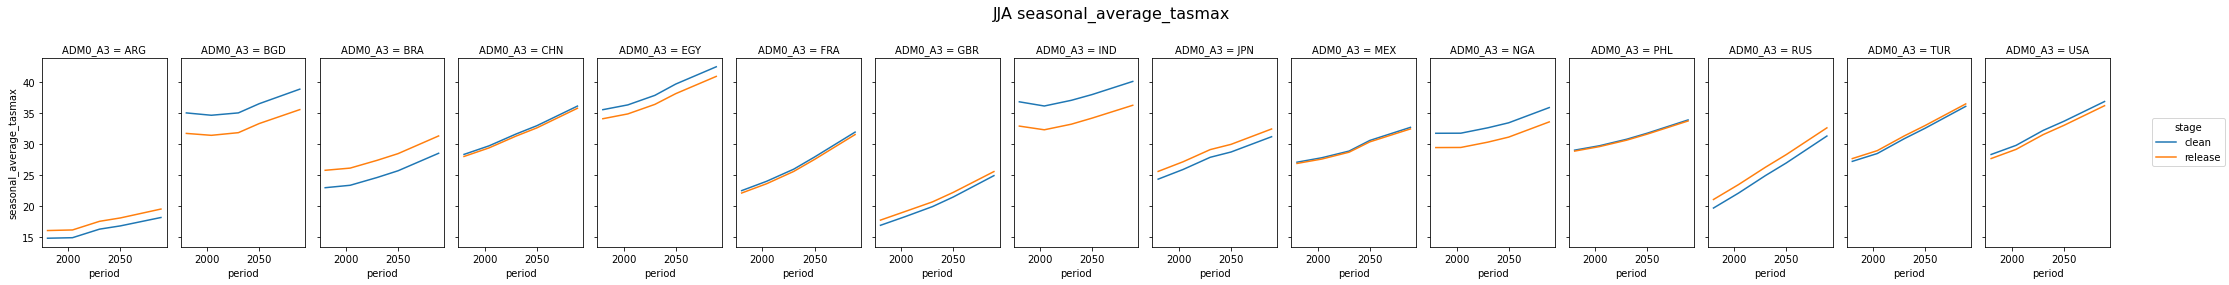

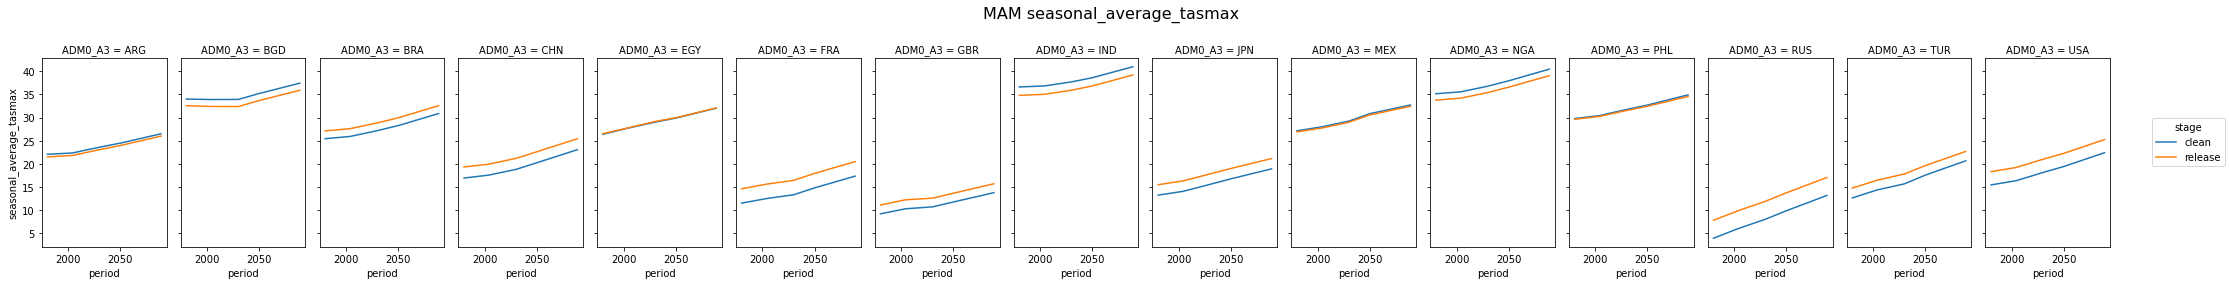

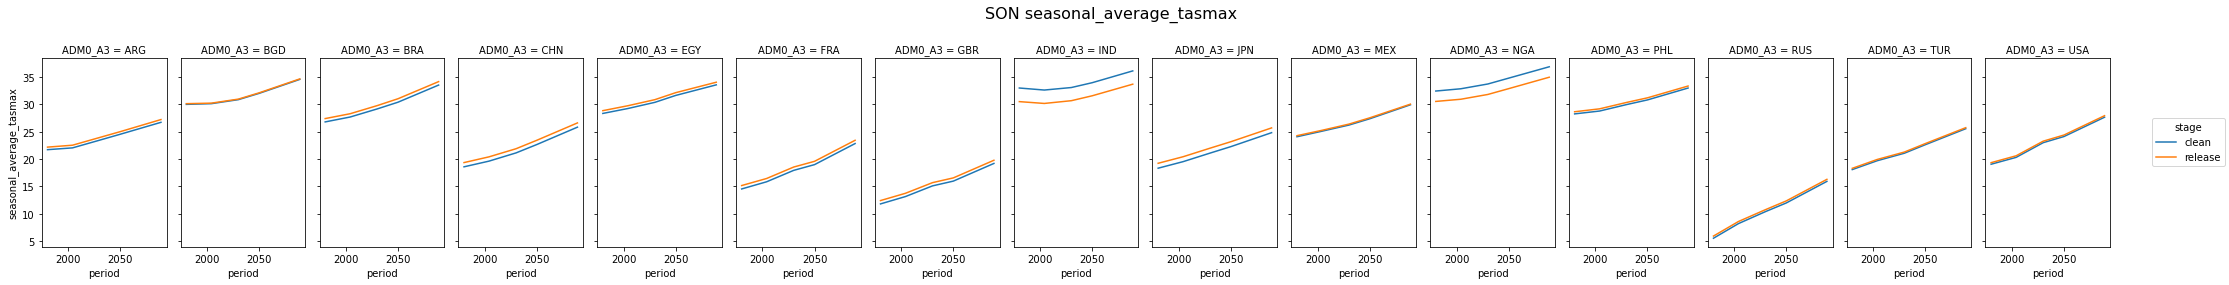

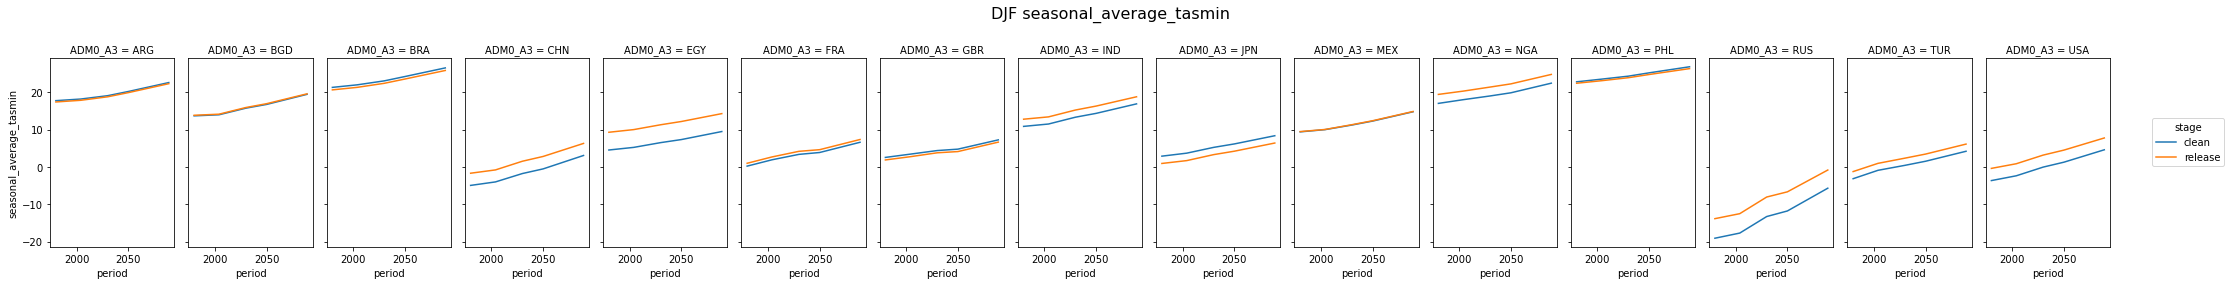

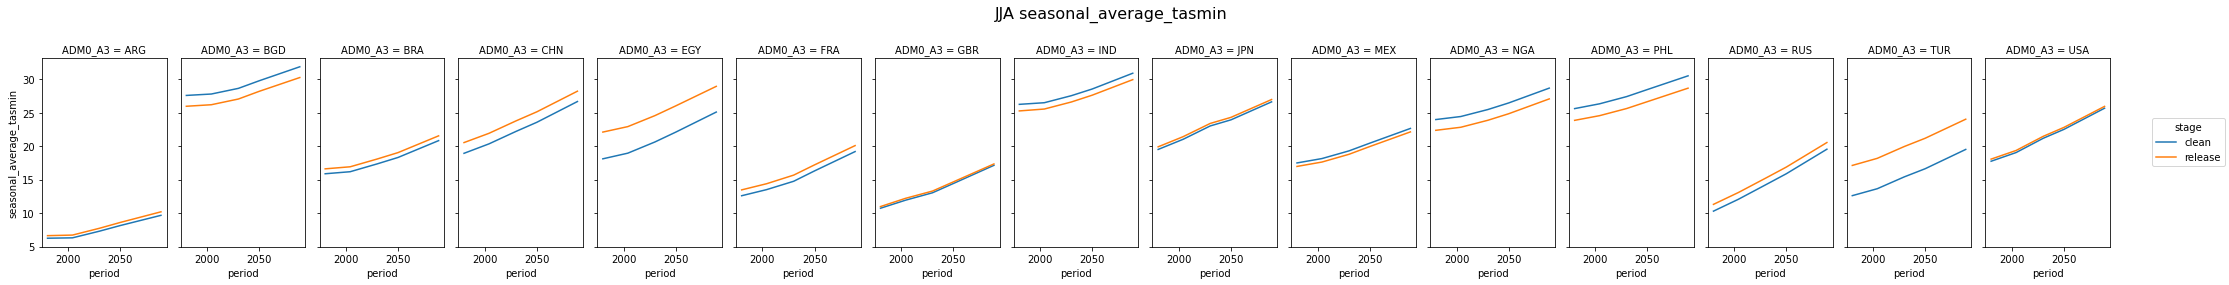

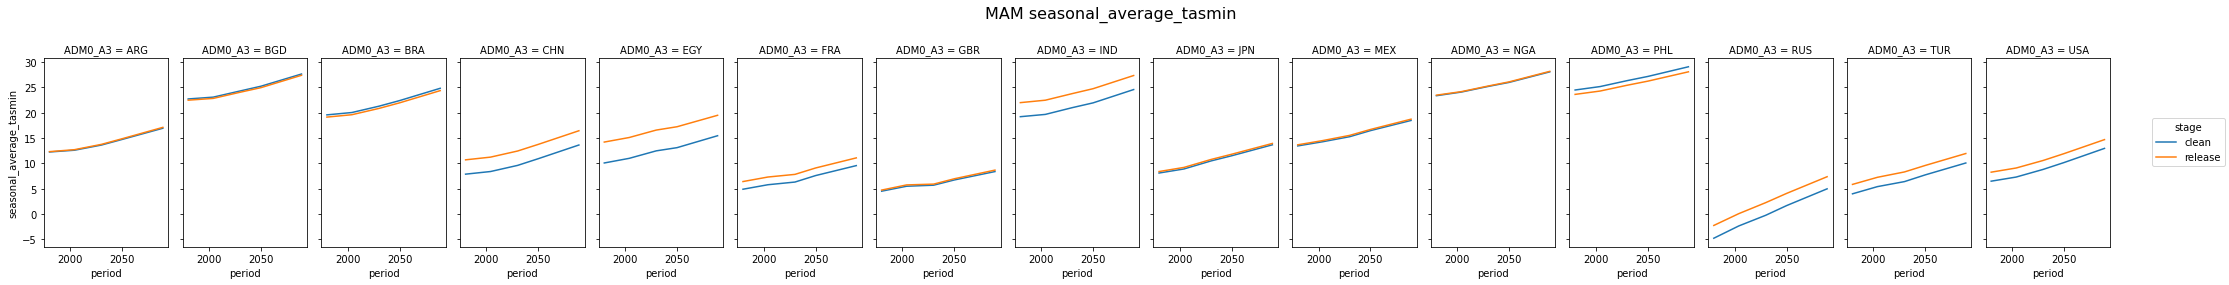

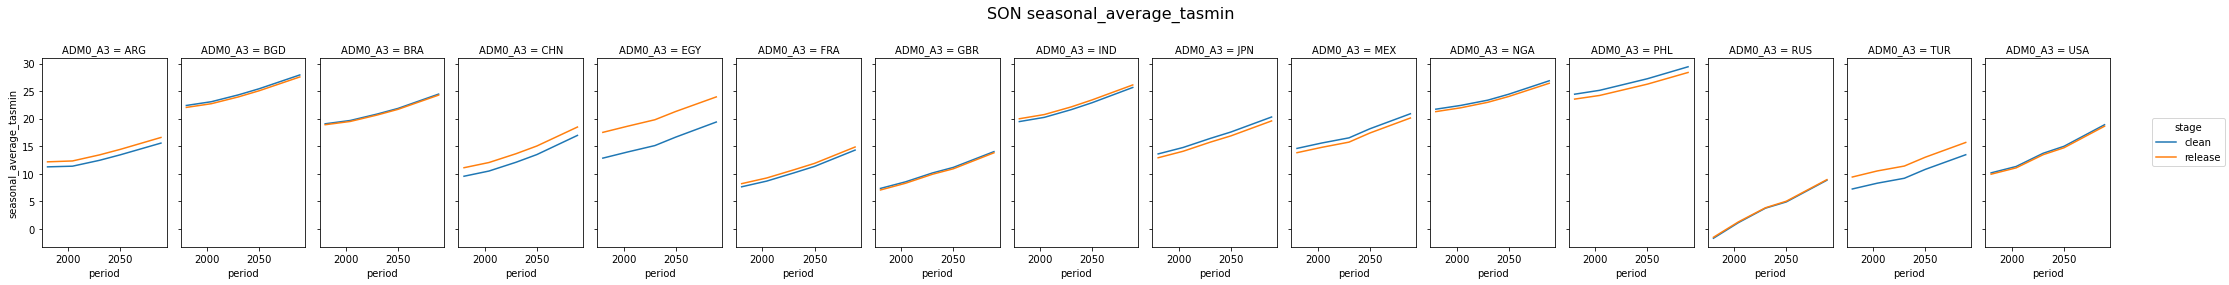

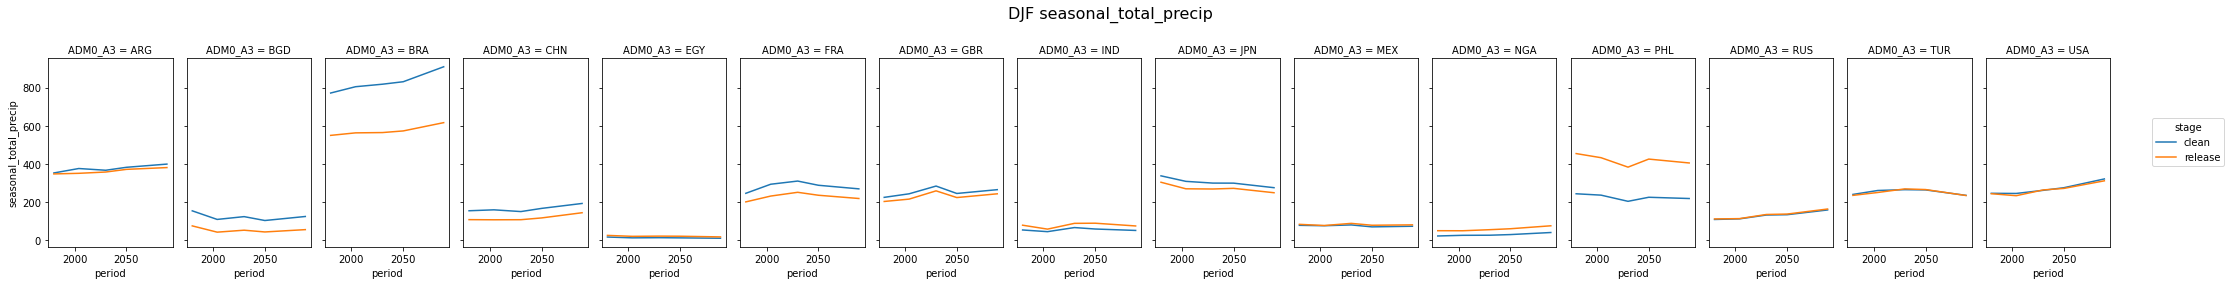

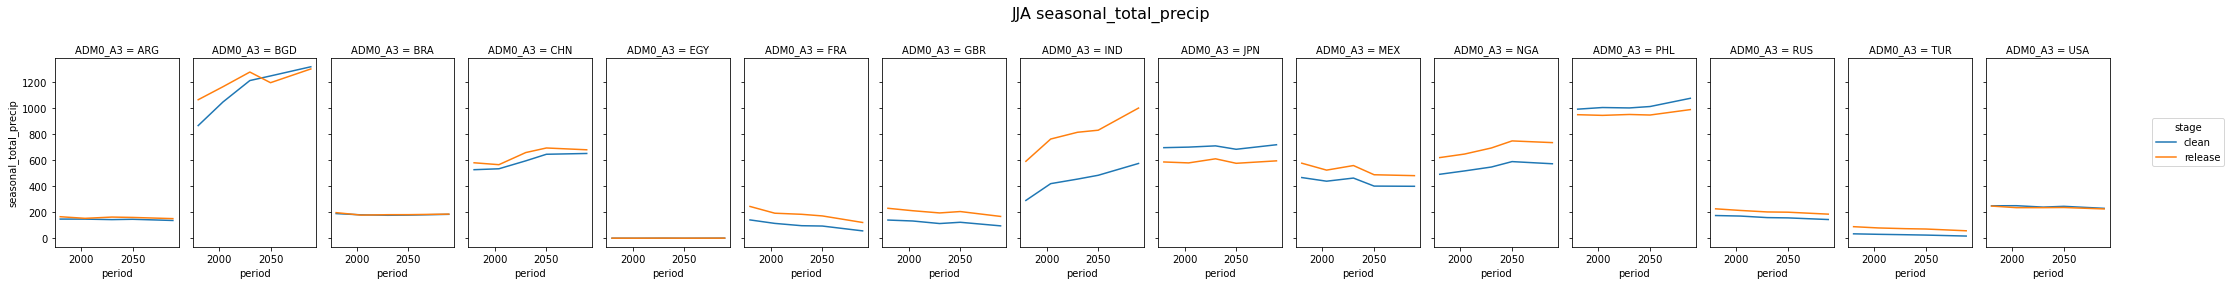

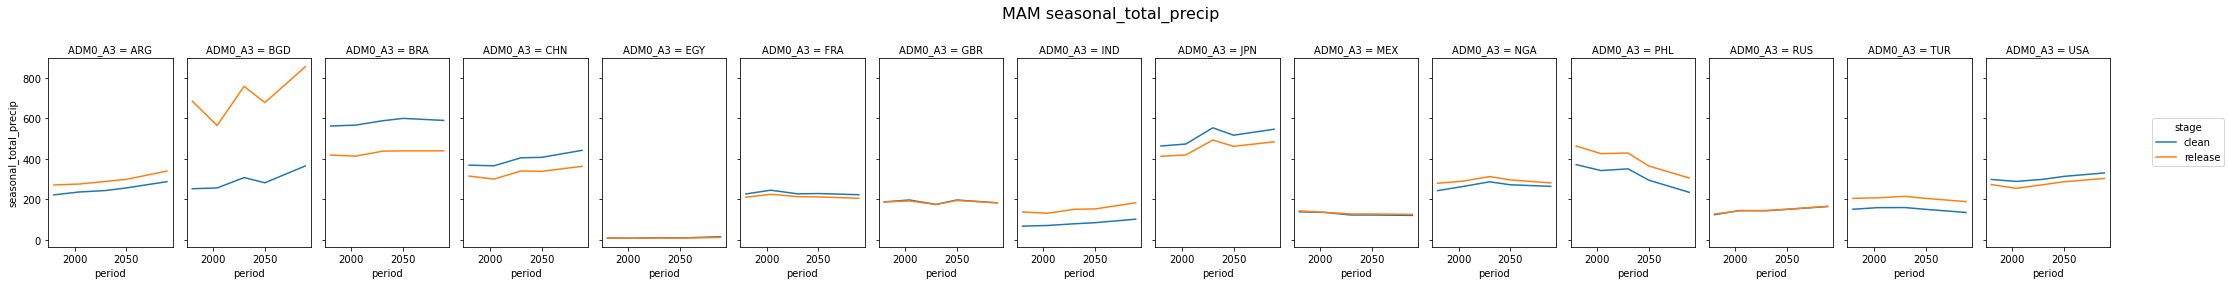

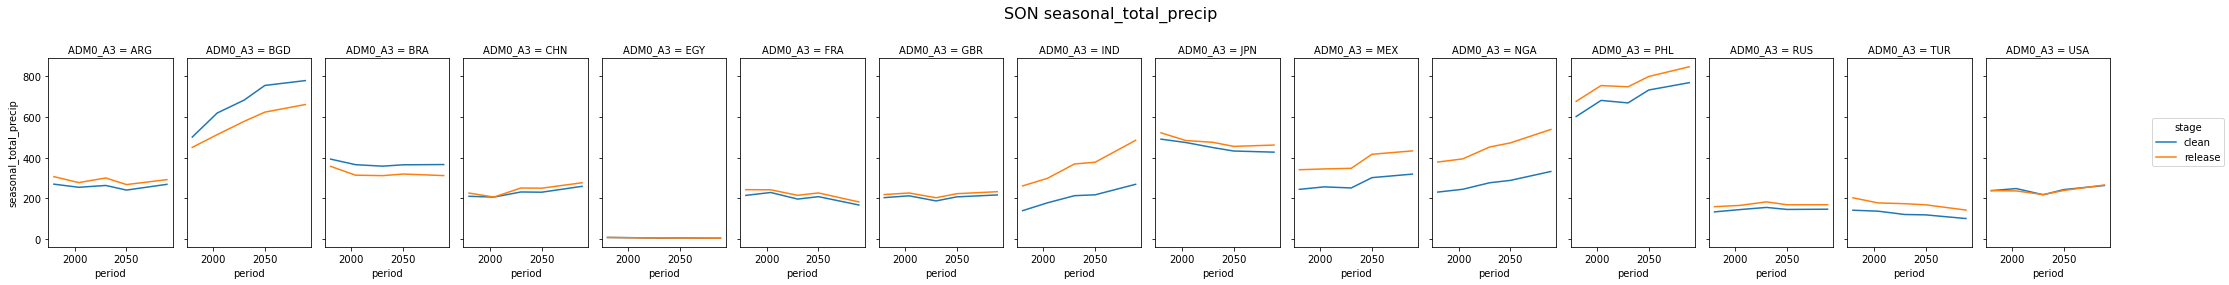

In [42]:
ds = all_data_adm0[source_id].sel(scen=experiment_id)

for v in ds.data_vars.keys():
    if 'season' in ds[v].dims:
        continue

    p = ds[v].plot.line(x='period', col='ADM0_A3', figsize=(30, 4))
    p.fig.suptitle(f'{v}', size=16)
    p.fig.subplots_adjust(top=0.8)
    p.fig.set_facecolor('white')

for v in ds.data_vars.keys():

    if 'season' not in ds[v].dims:
        continue

    for season in ds[v].season.values:
        p = ds[v].sel(season=season).plot.line(x='period', col='ADM0_A3', figsize=(30, 4))
        
        p.fig.suptitle(f'{season} {v}', size=16)

        p.fig.subplots_adjust(top=0.8)
        p.fig.set_facecolor('white')